In [56]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import KMNIST
from matplotlib import pyplot as plt

SyntaxError: ignored

In [15]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [16]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [119]:
batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    KMNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    KMNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

O dataset usado foi o Kuzushiji-MNIST que é uma variação do MNIST que contem 70000 imagens divididas assim como no MNIST em 10 classes

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [121]:
d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [122]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [123]:
def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='mean'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

Como parametro de reduçnao foi usado o mean que por sua vez faz a media da soma saida do modelo pelo numero de elementos e como otimizador para a função de perda foi usado o otimizador ADAM

Treinamento e teste do modelo, para esse experimento foram usadas 20 epocas

====> Test set loss: 0.1223
====> Epoch: 1 Average loss: 0.0043
====> Test set loss: 0.0021
====> Epoch: 2 Average loss: 0.0018
====> Test set loss: 0.0019
====> Epoch: 3 Average loss: 0.0017
====> Test set loss: 0.0018
====> Epoch: 4 Average loss: 0.0017
====> Test set loss: 0.0018
====> Epoch: 5 Average loss: 0.0017
====> Test set loss: 0.0018
====> Epoch: 6 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 7 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 8 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 9 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 10 Average loss: 0.0017
====> Test set loss: 0.0017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


====> Epoch: 11 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 12 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 13 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 14 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 15 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 16 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 17 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 18 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 19 Average loss: 0.0017
====> Test set loss: 0.0017
====> Epoch: 20 Average loss: 0.0017
====> Test set loss: 0.0017


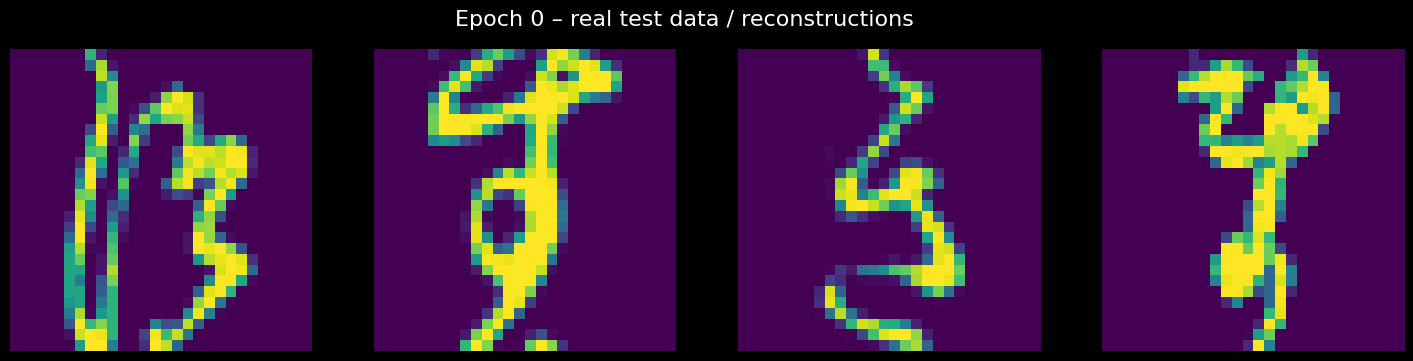

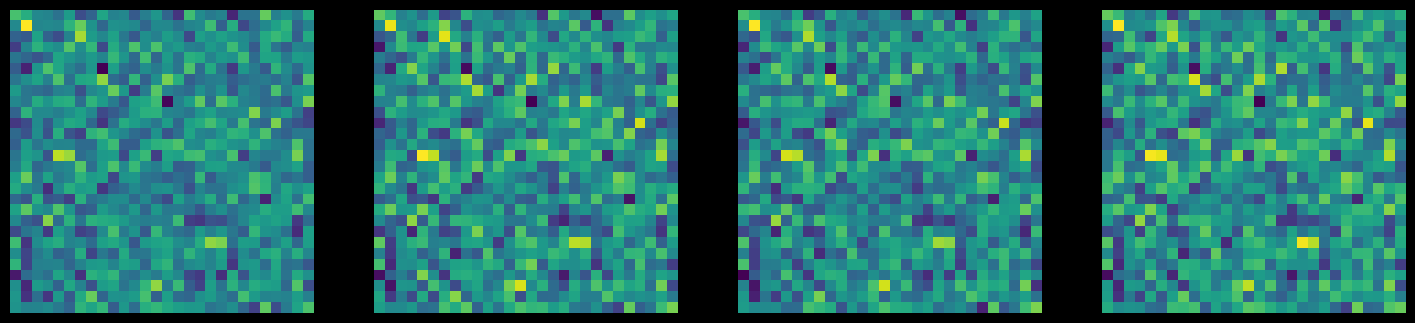

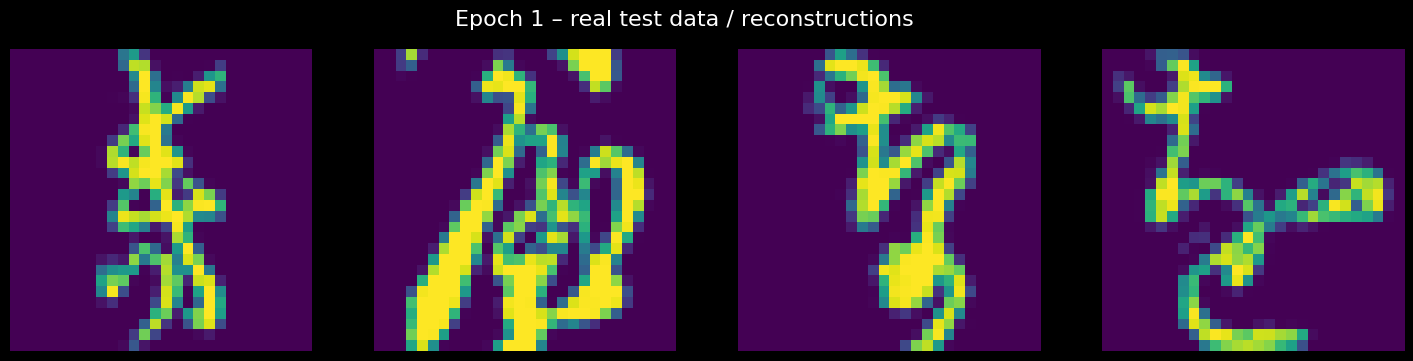

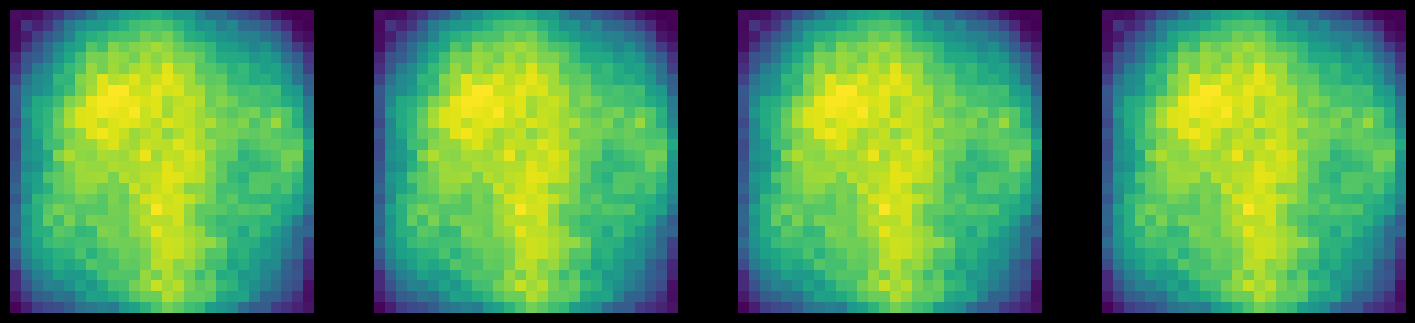

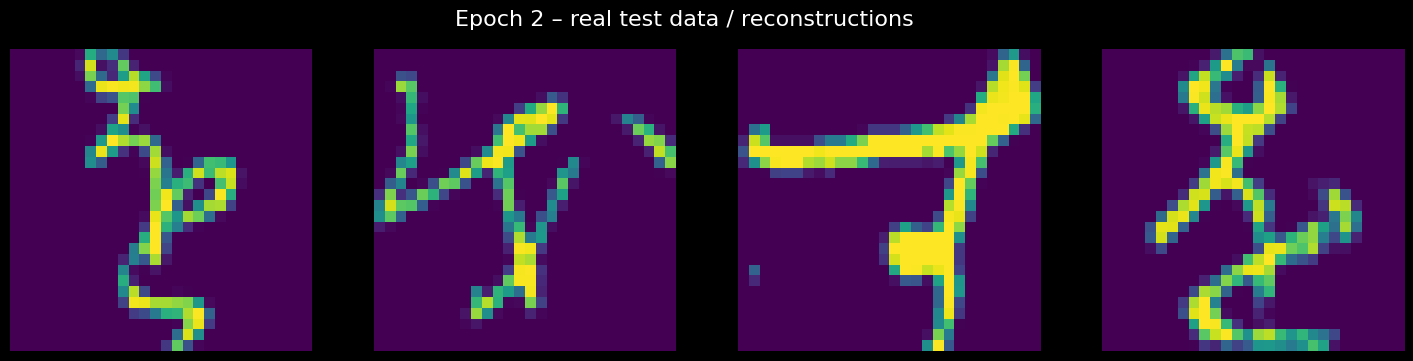

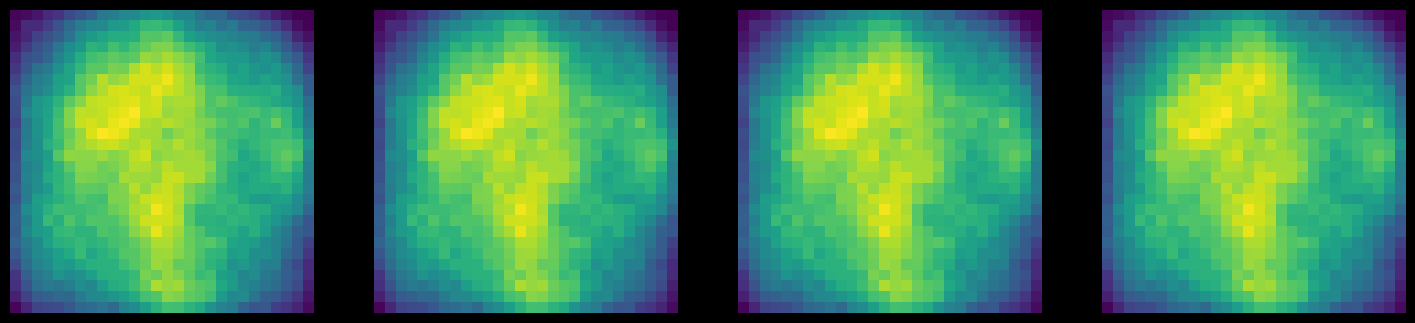

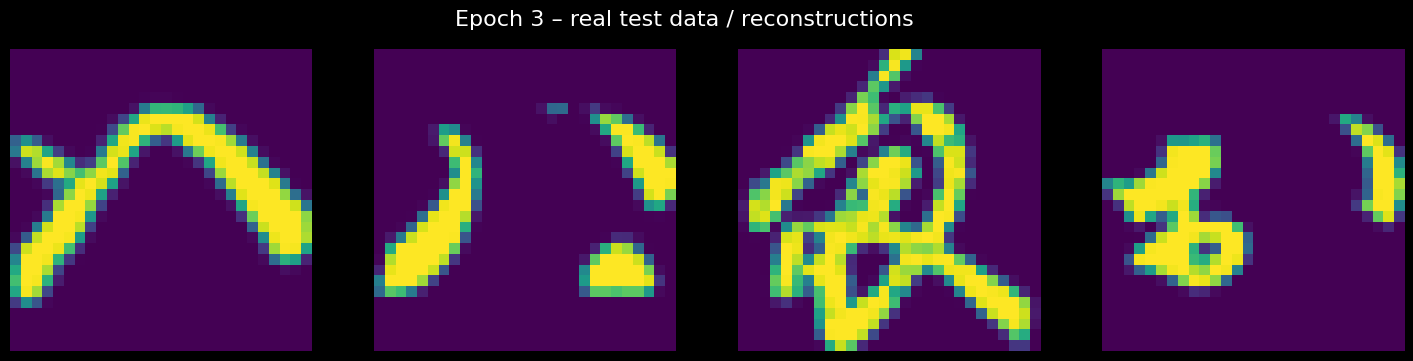

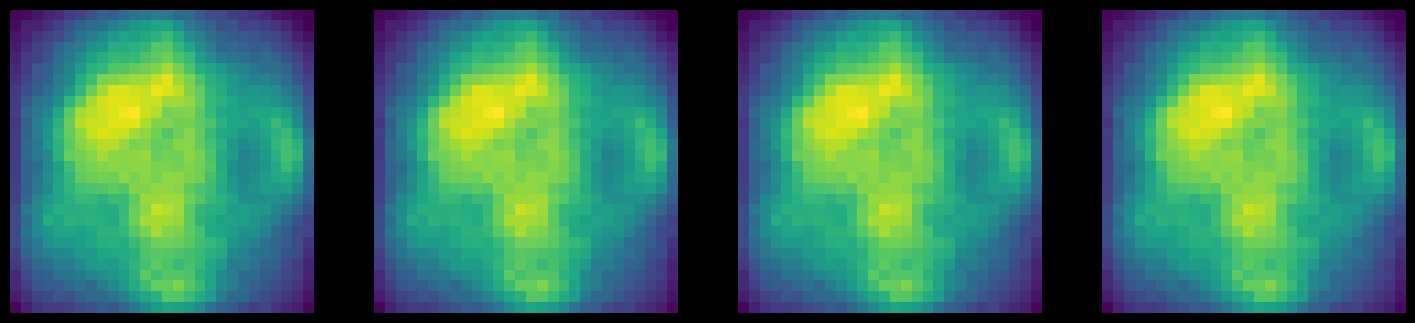

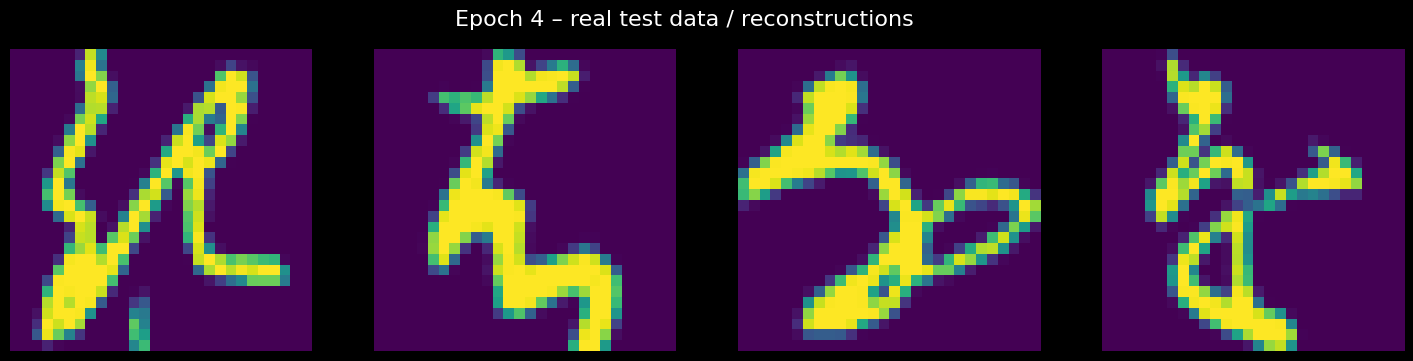

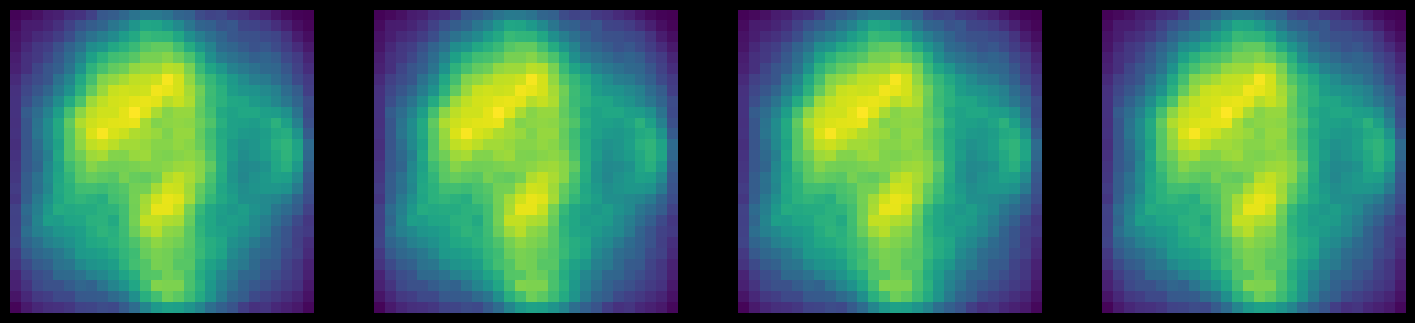

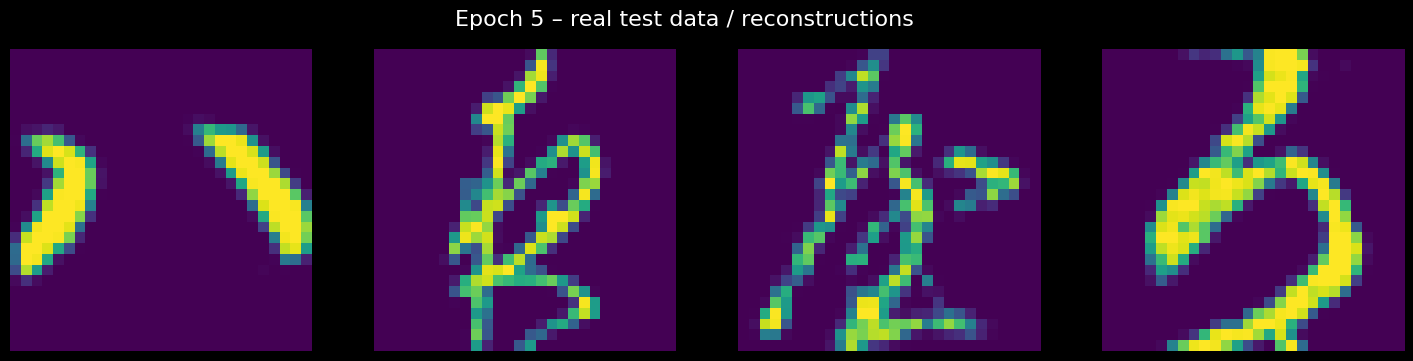

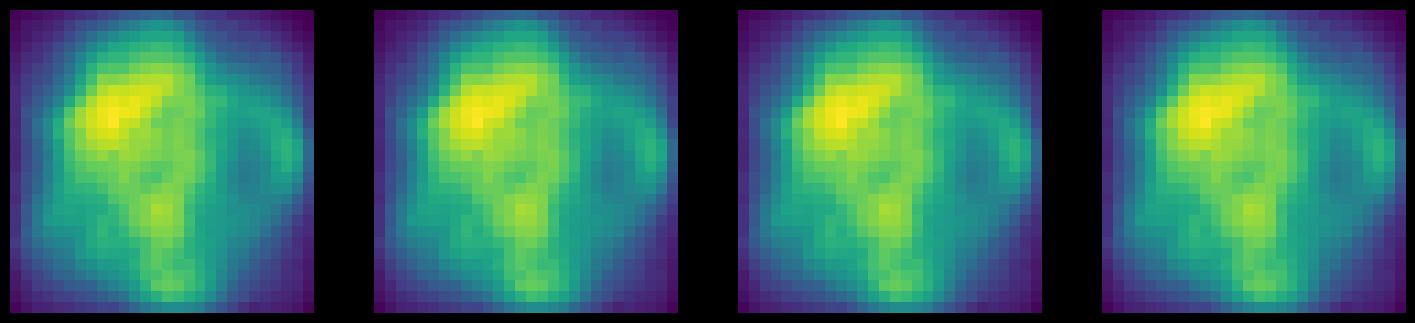

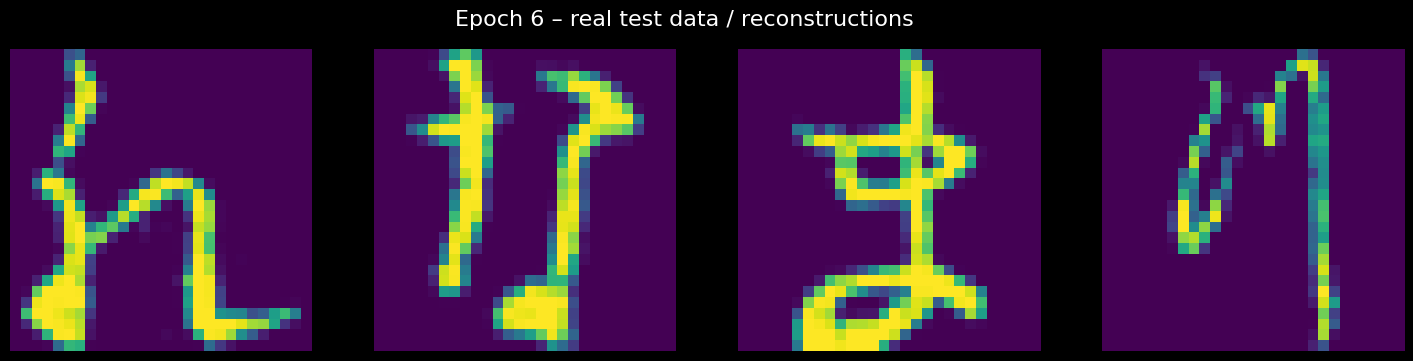

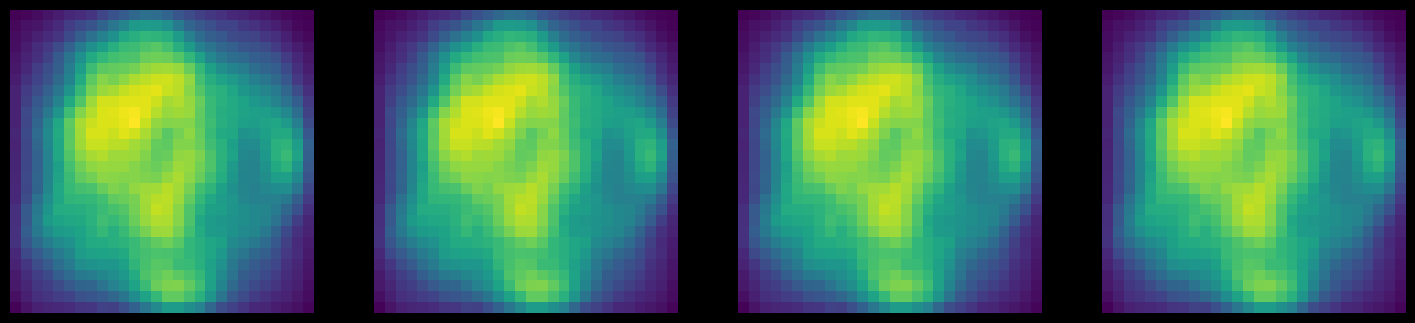

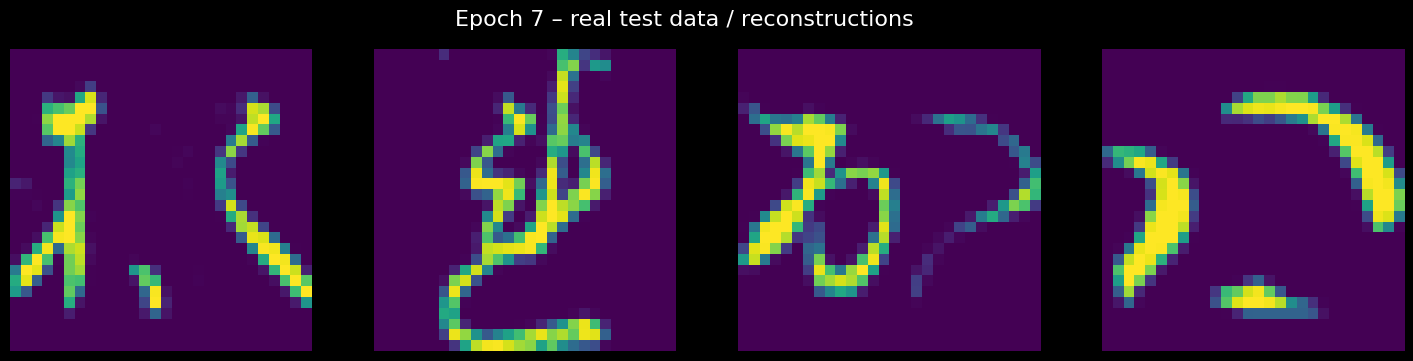

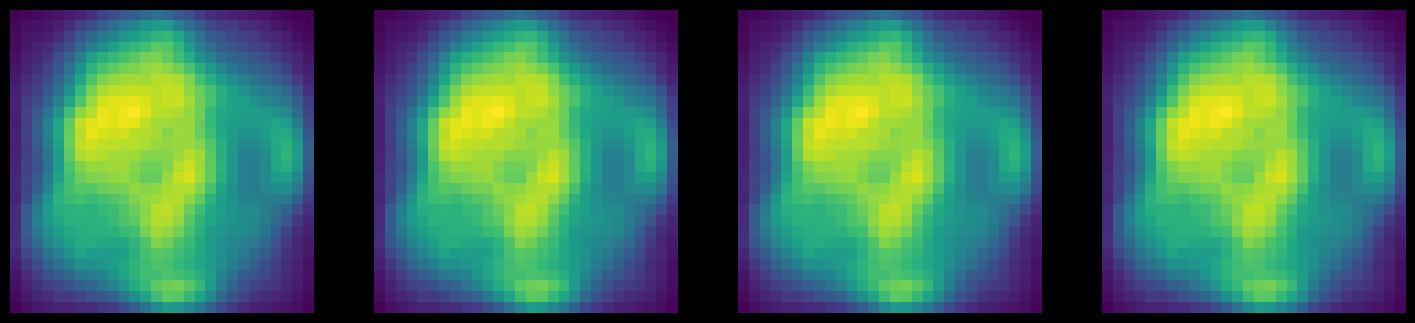

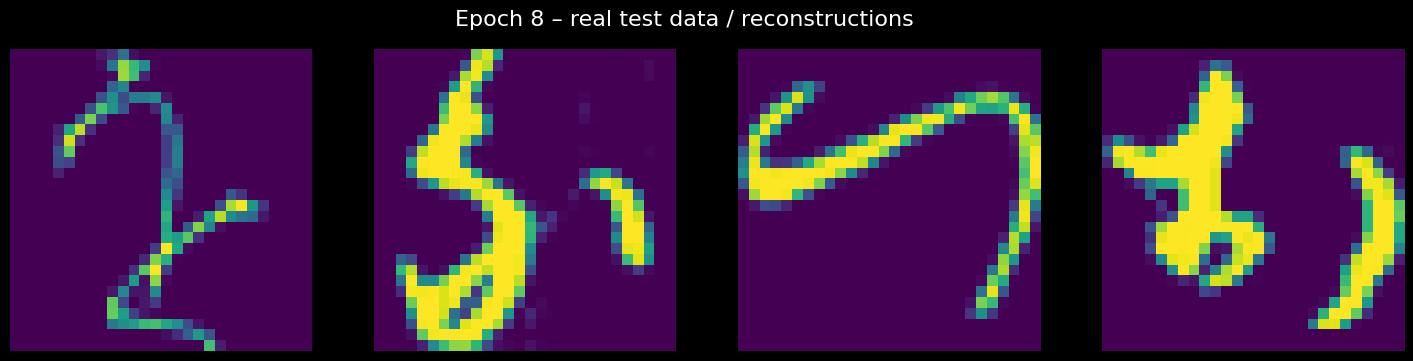

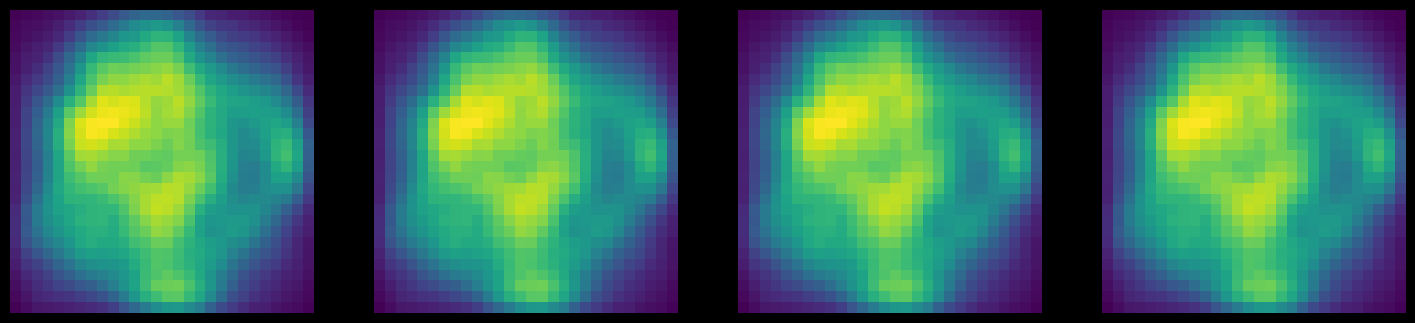

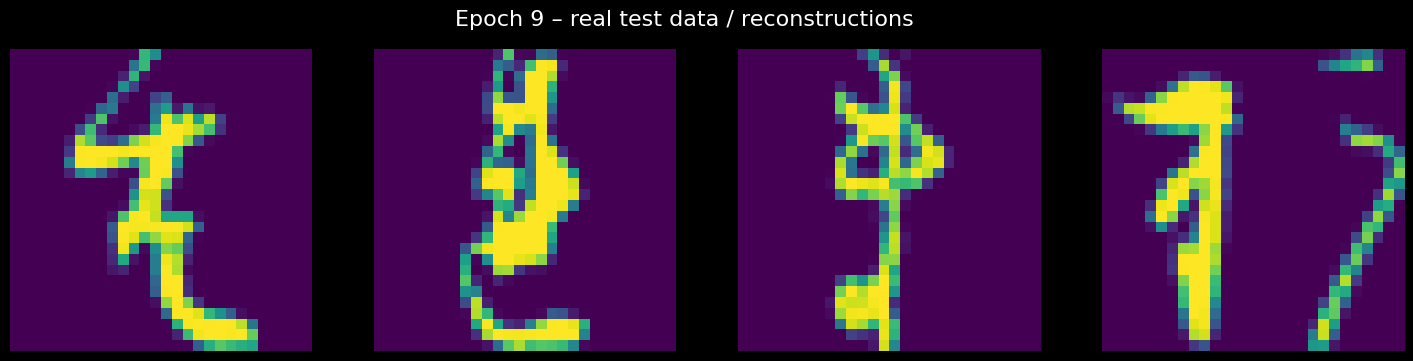

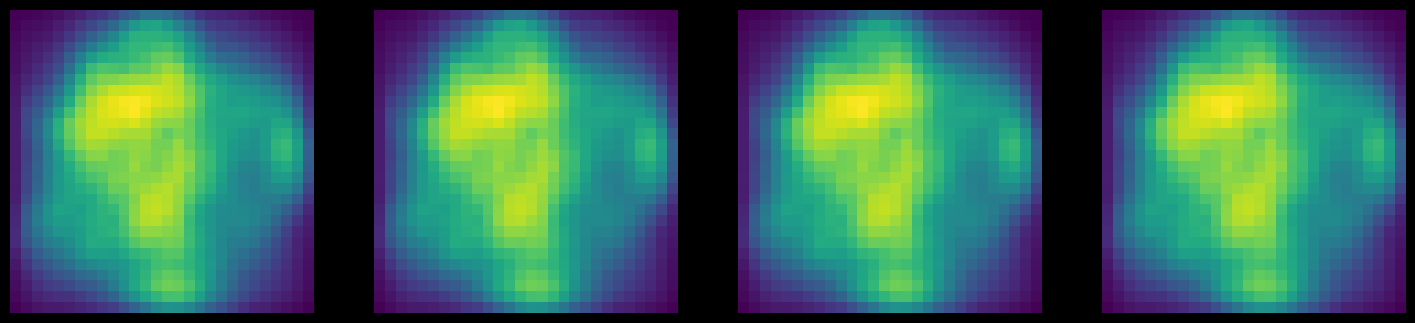

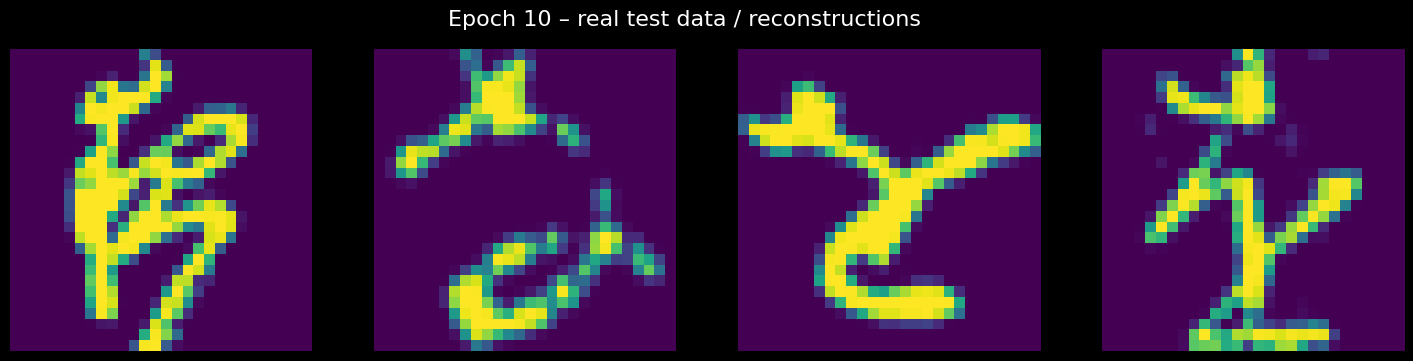

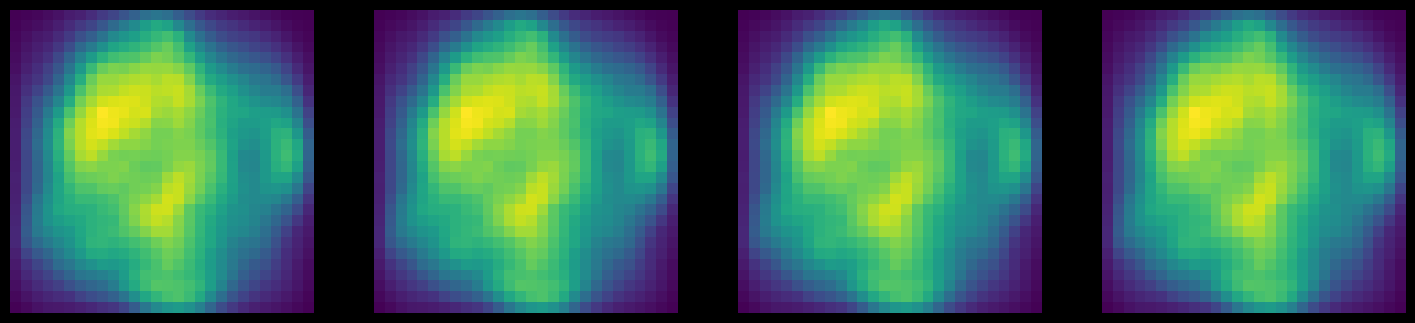

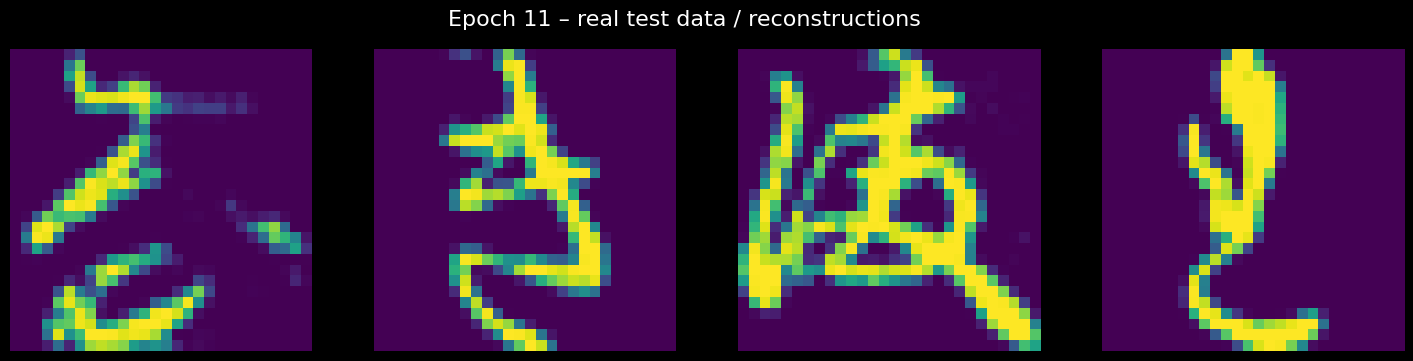

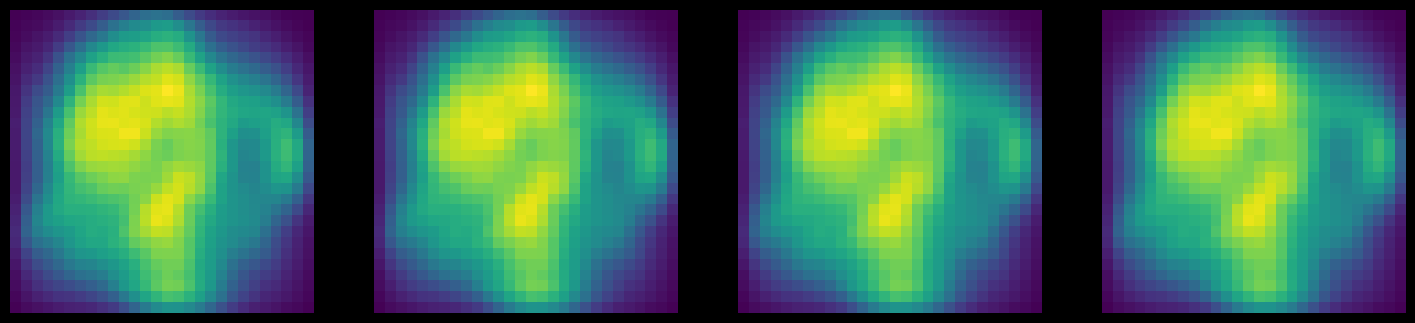

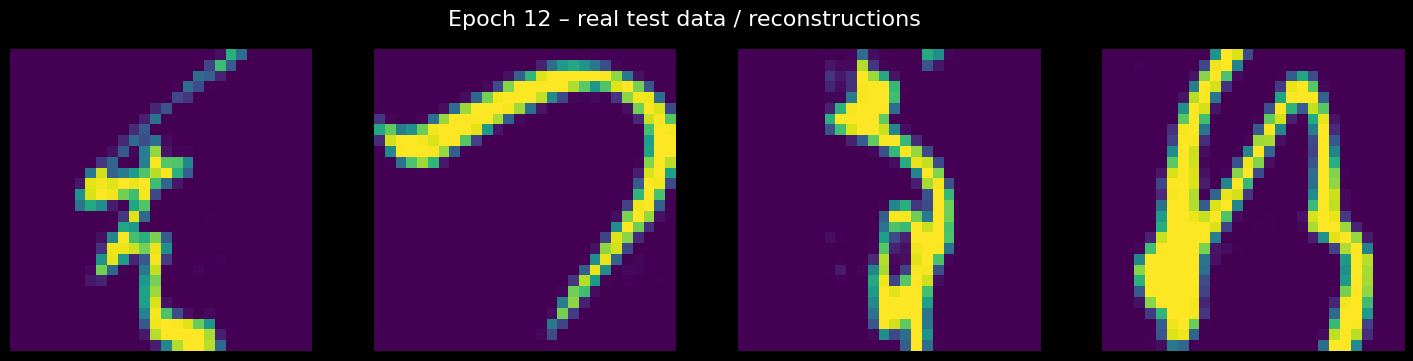

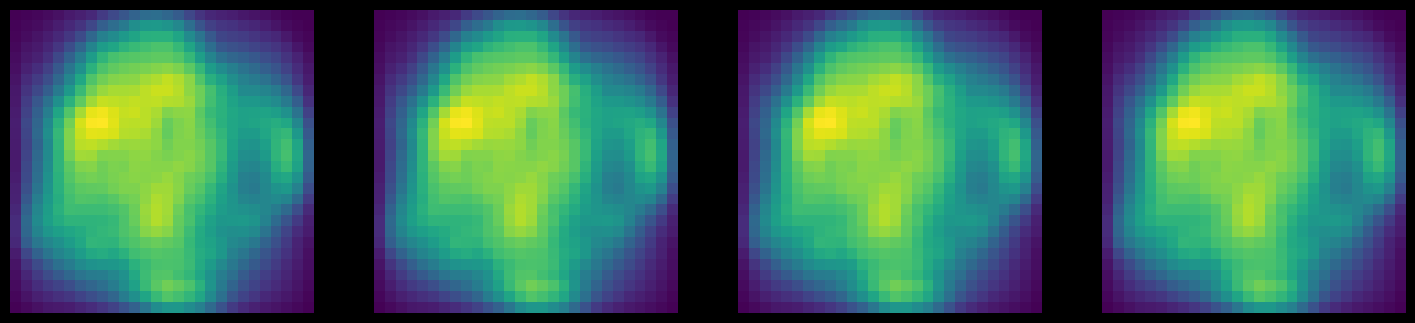

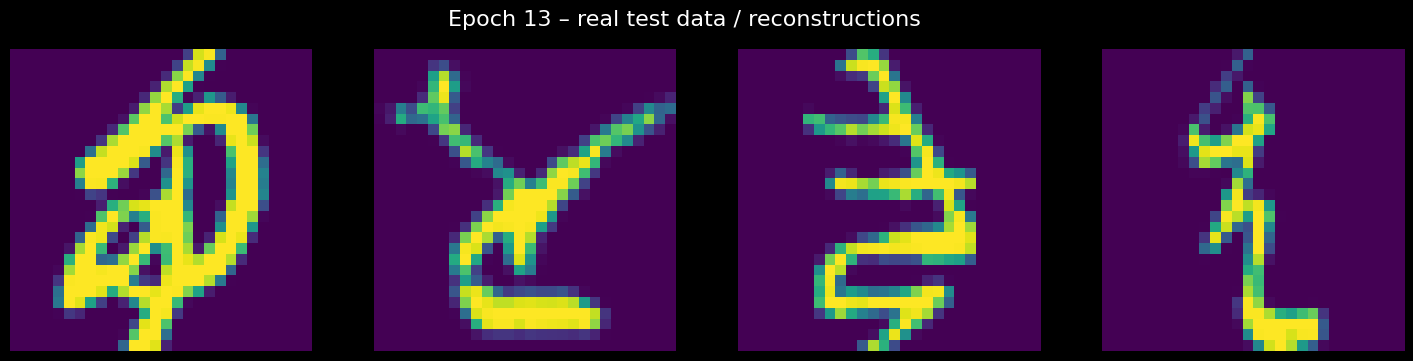

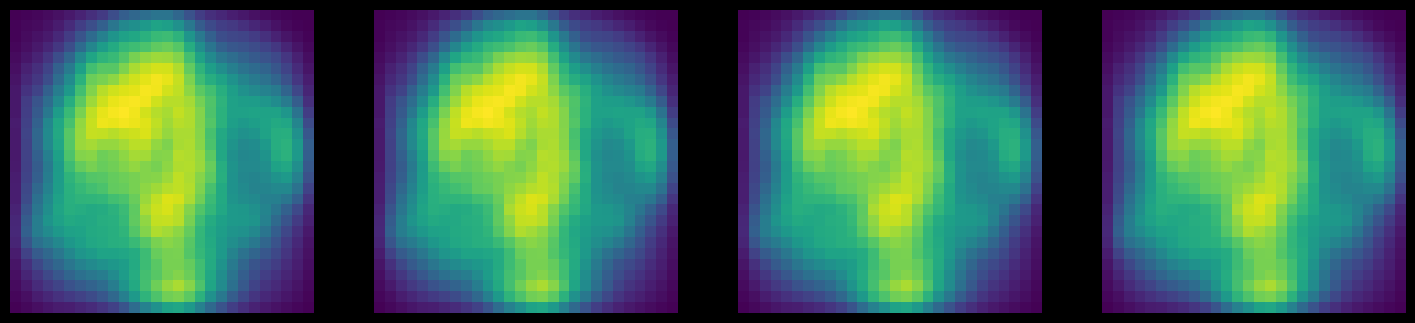

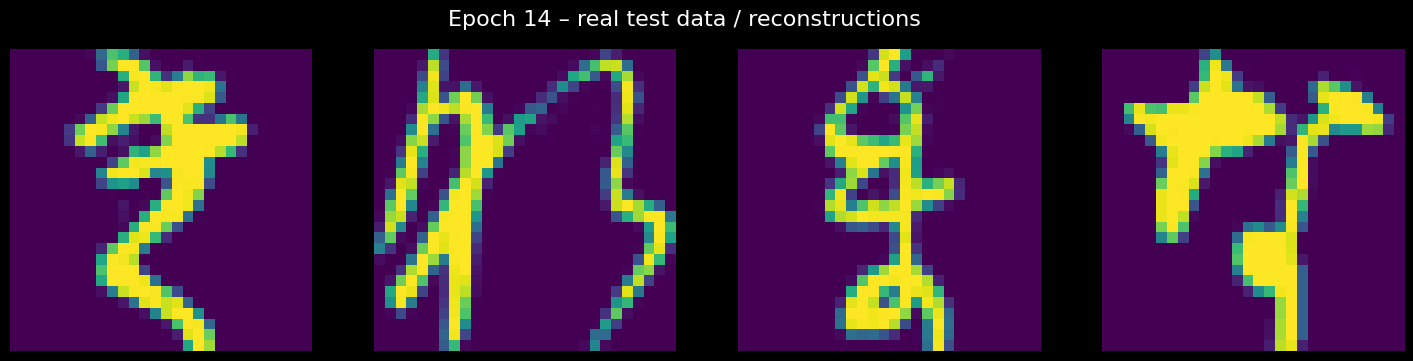

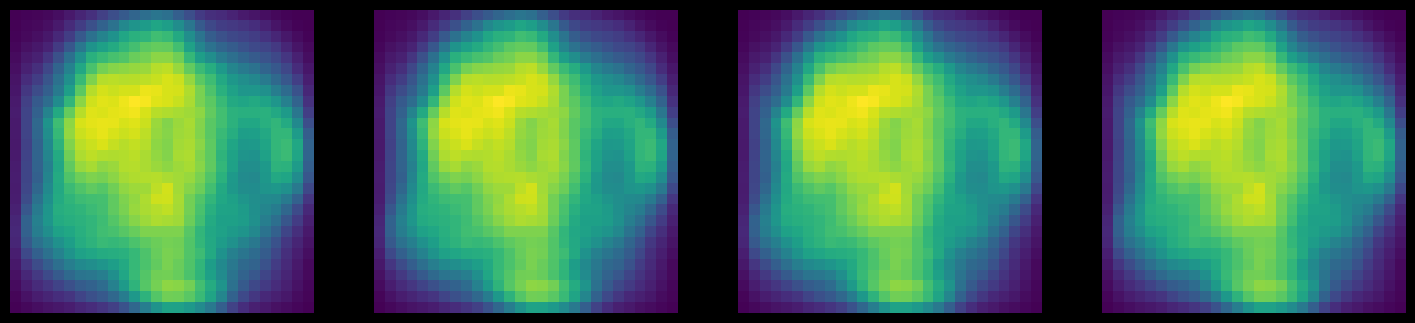

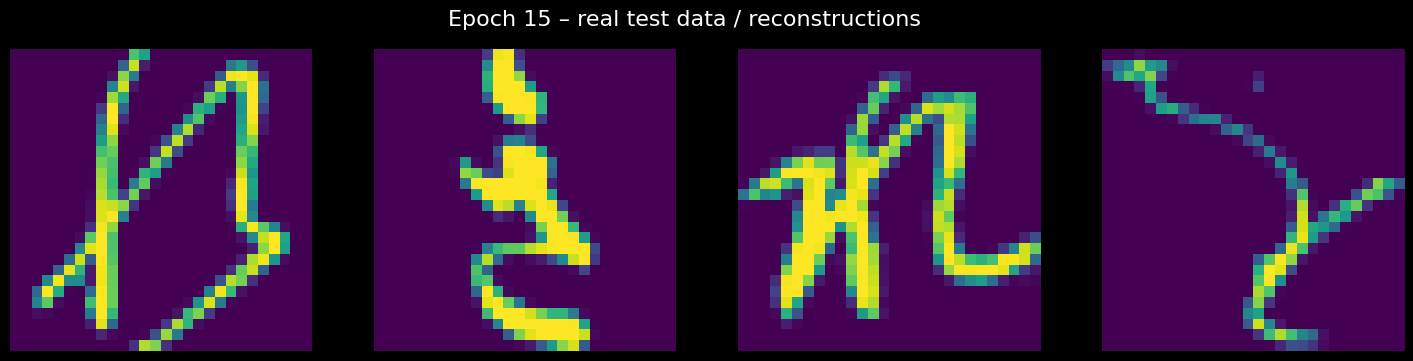

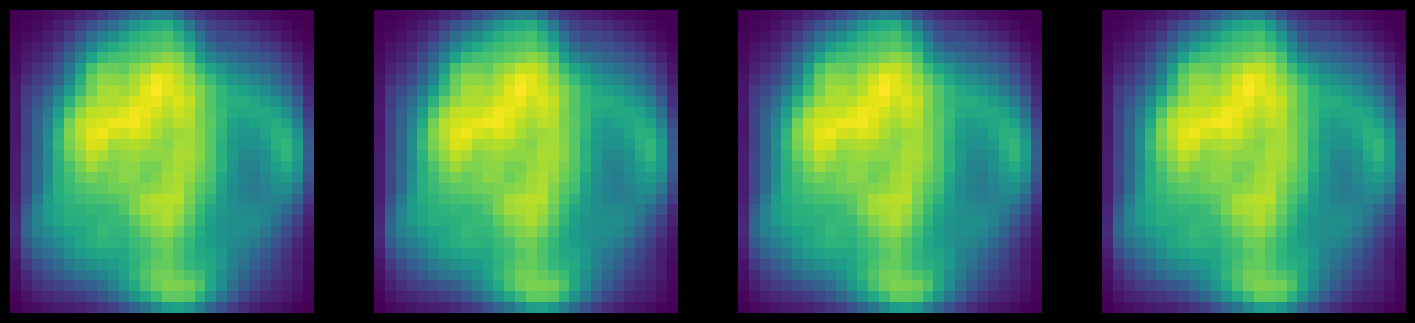

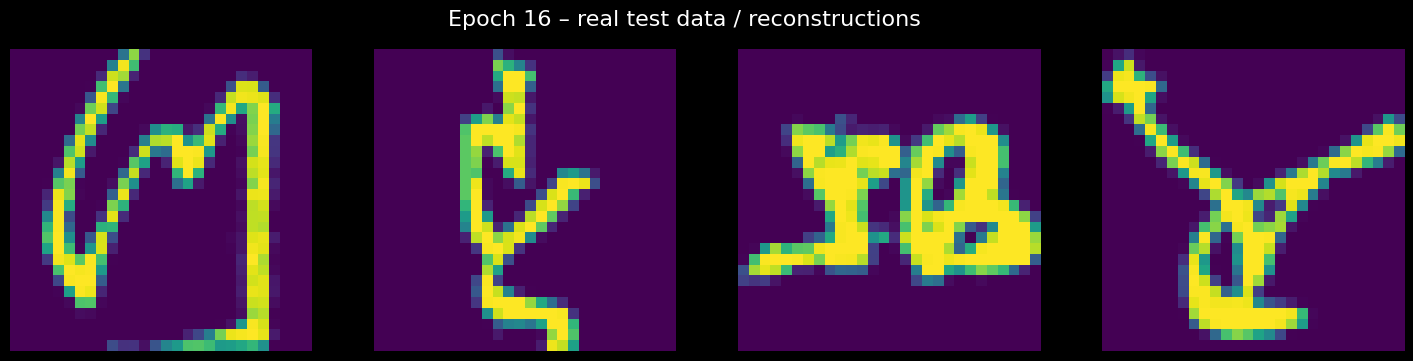

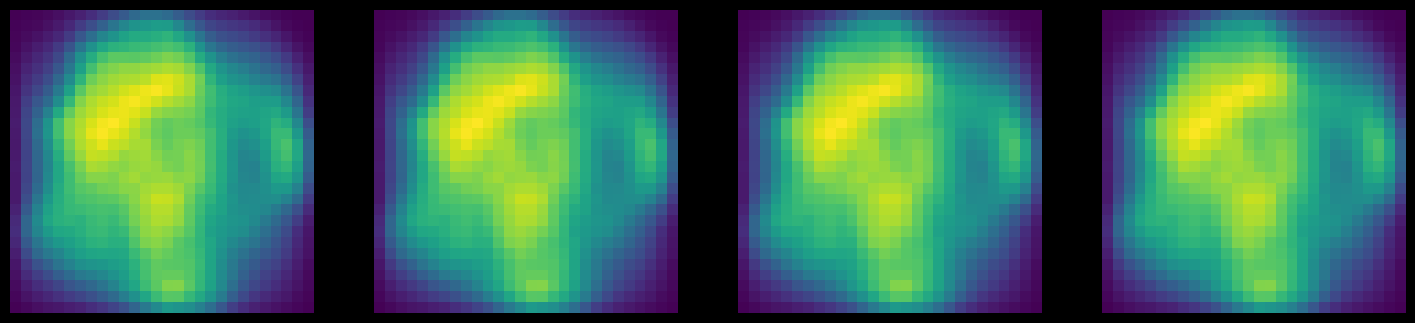

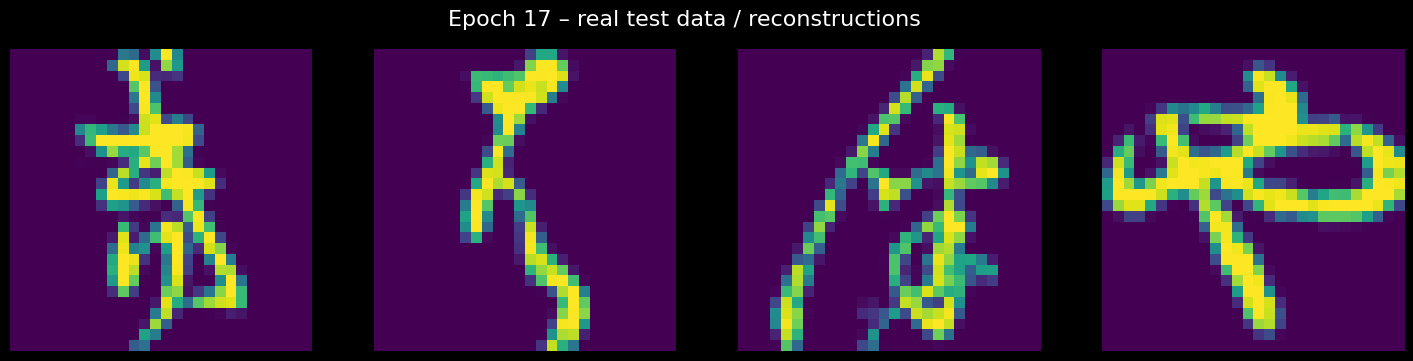

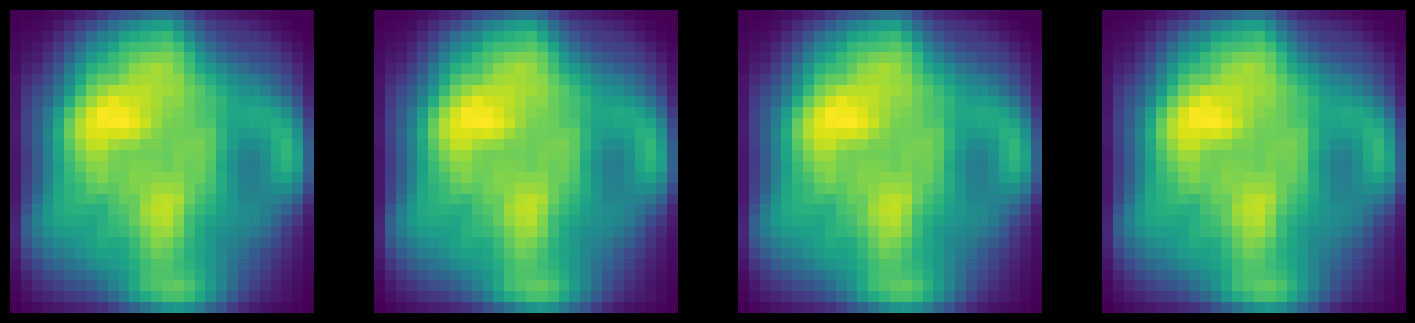

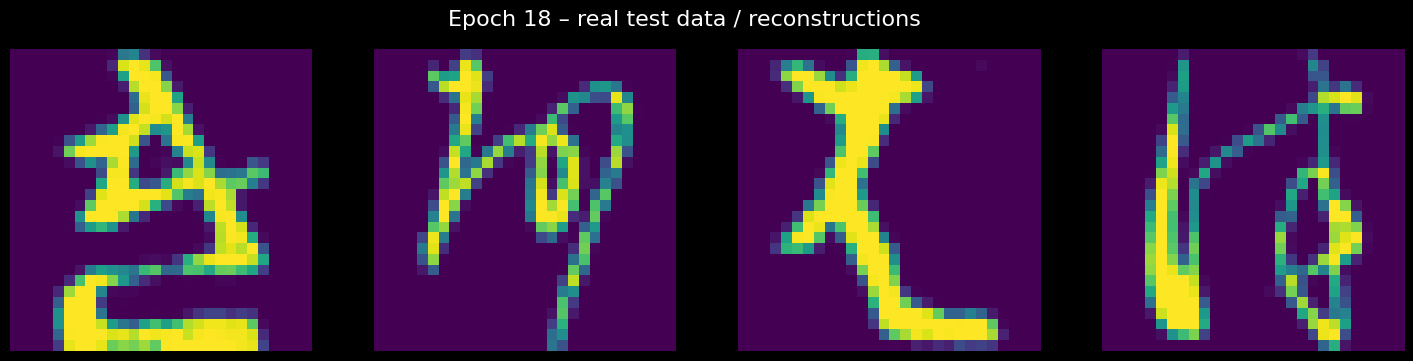

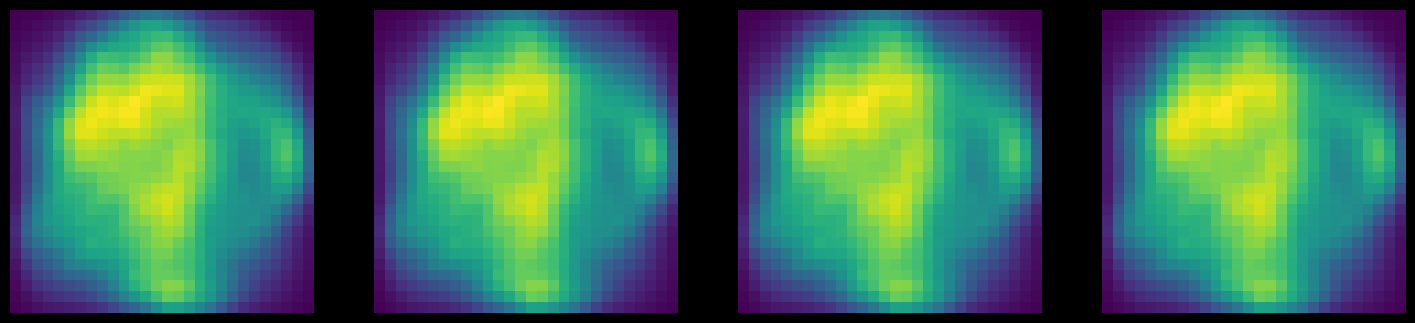

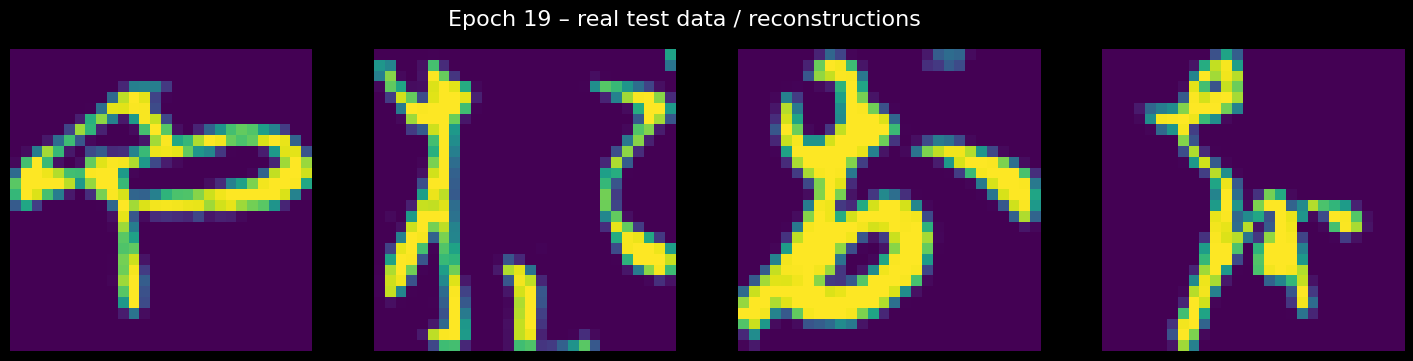

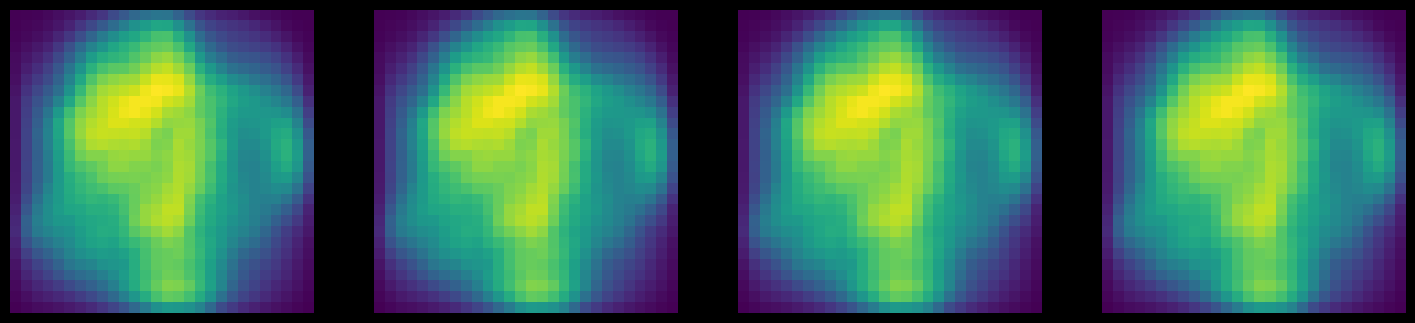

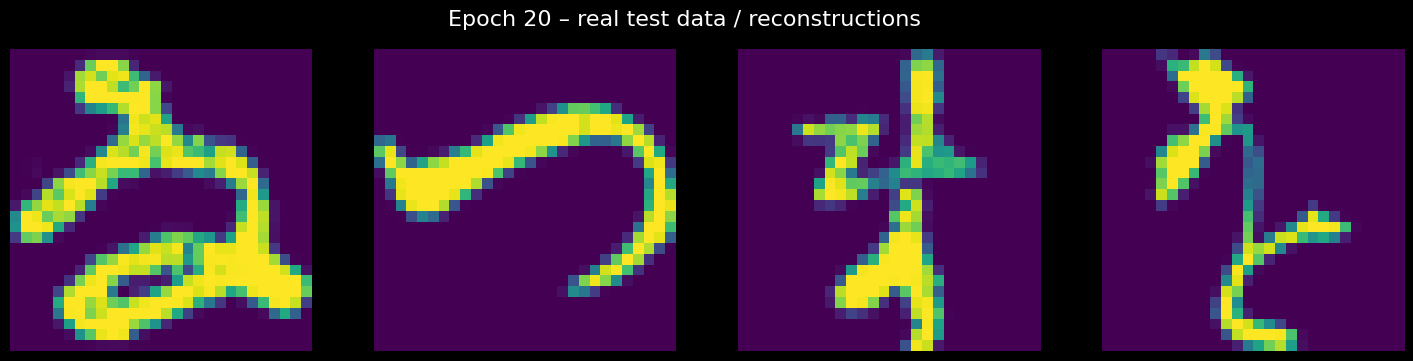

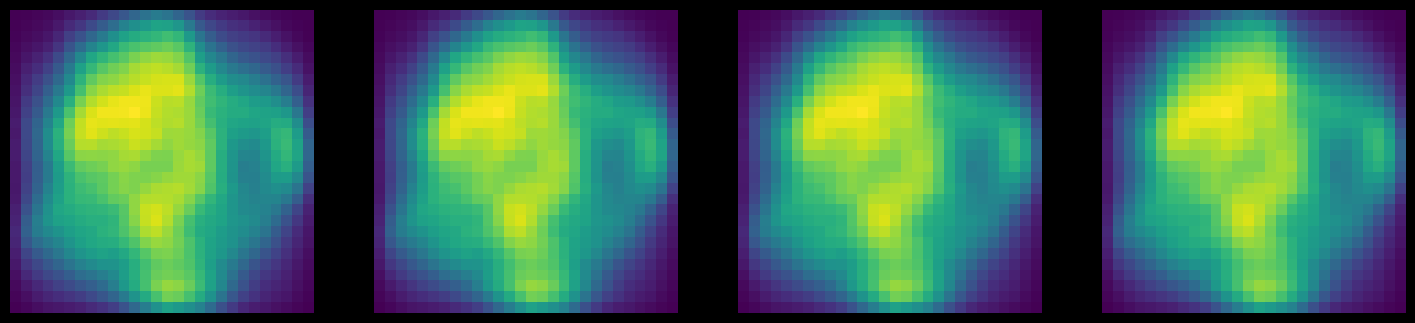

In [124]:
epochs = 20
lossArray1 = []
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    lossArray1.append(test_loss)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

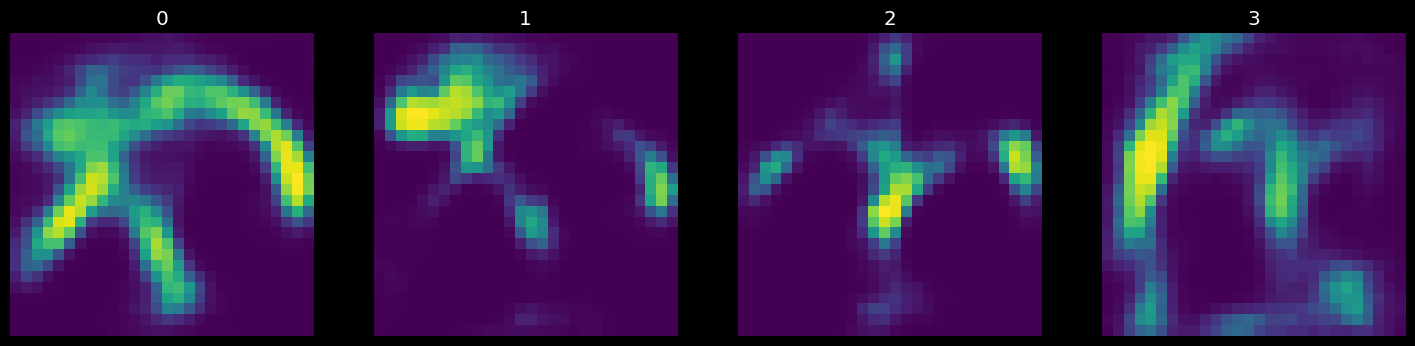

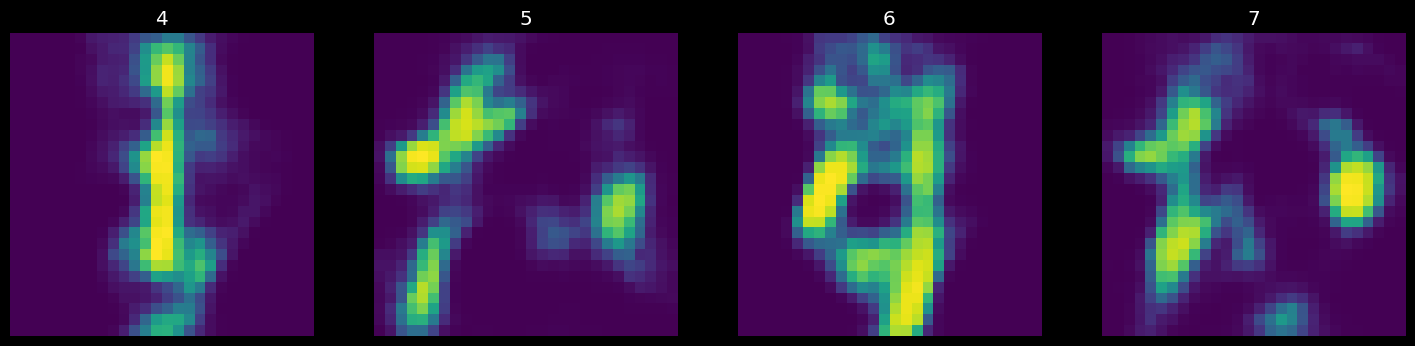

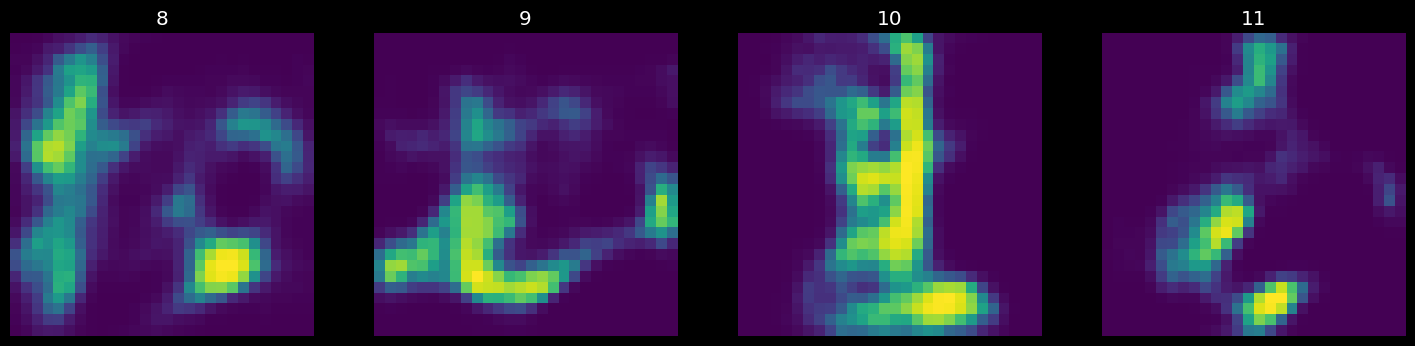

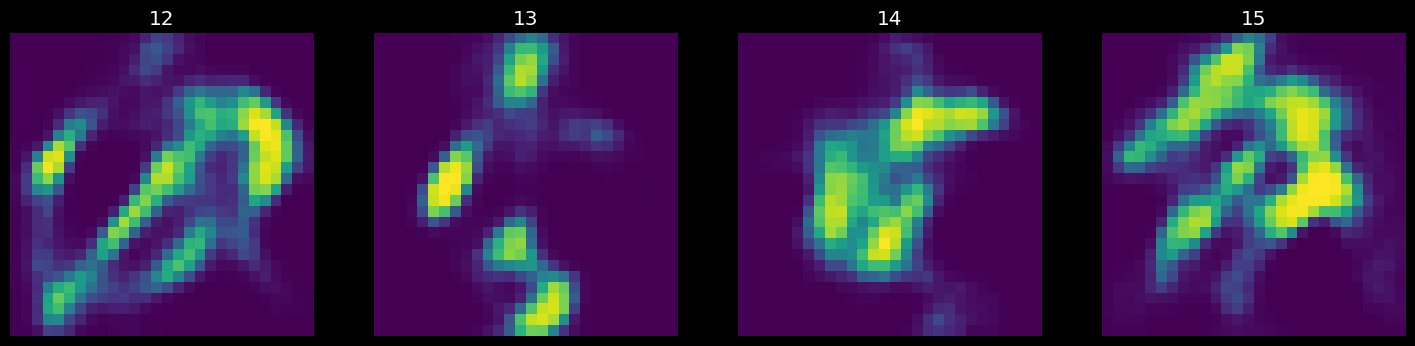

In [43]:
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

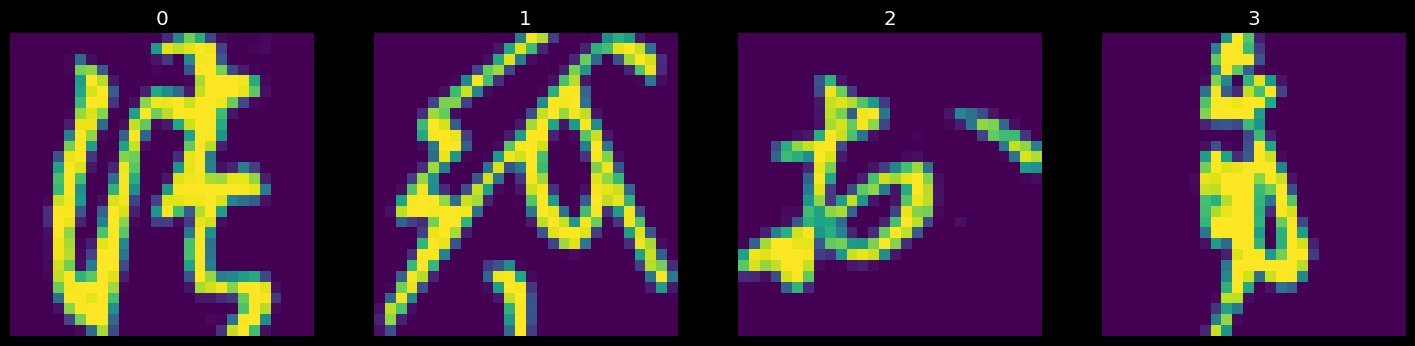

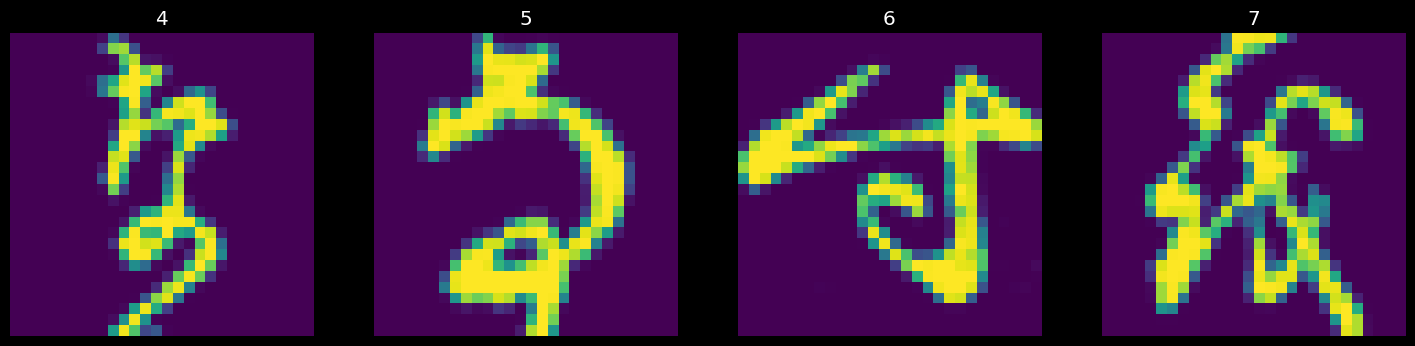

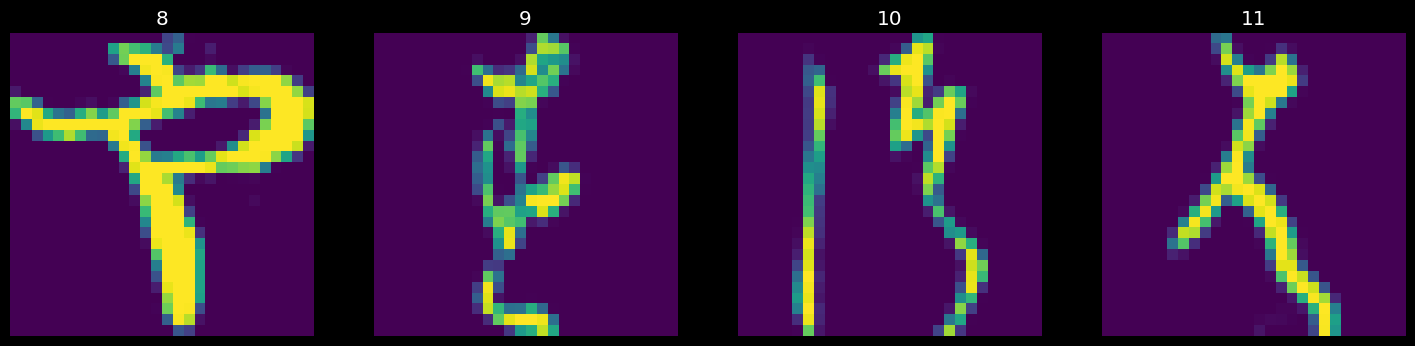

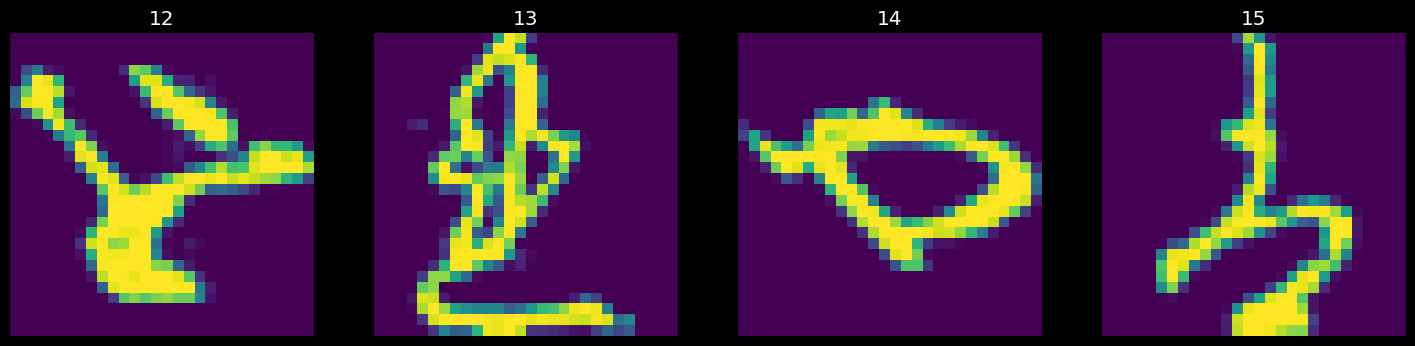

In [44]:
display_images(None, x, 4, count=True)

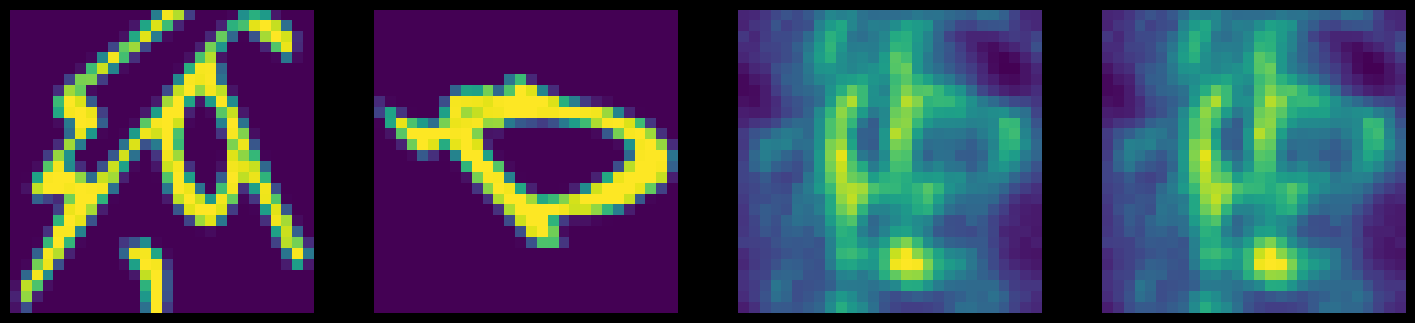

In [45]:
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

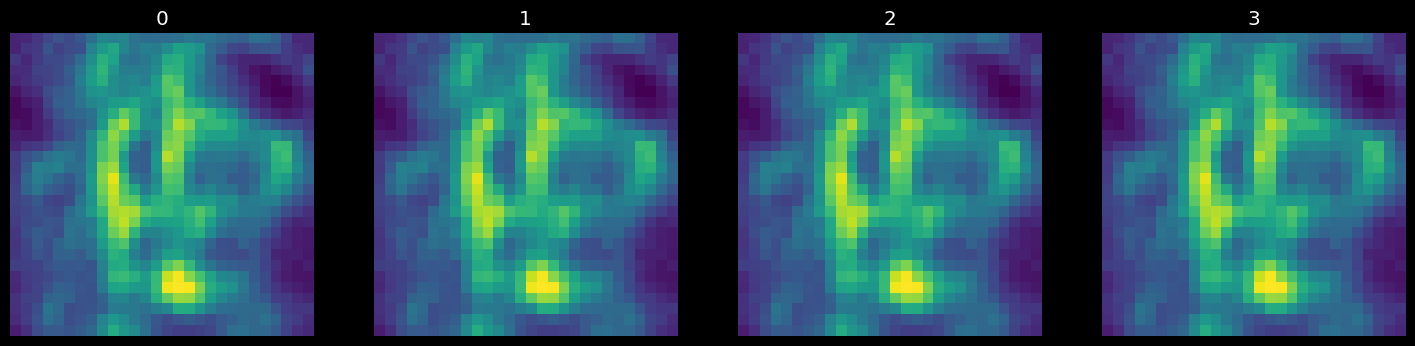

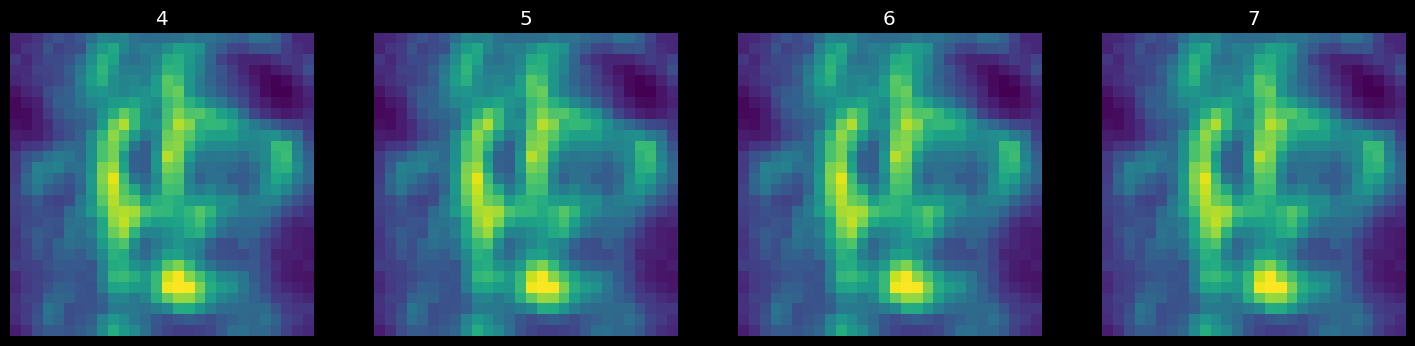

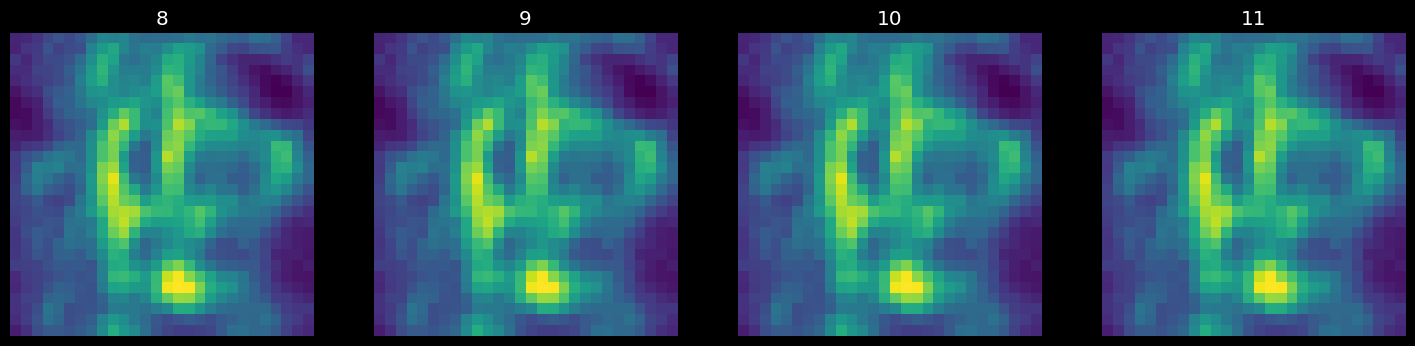

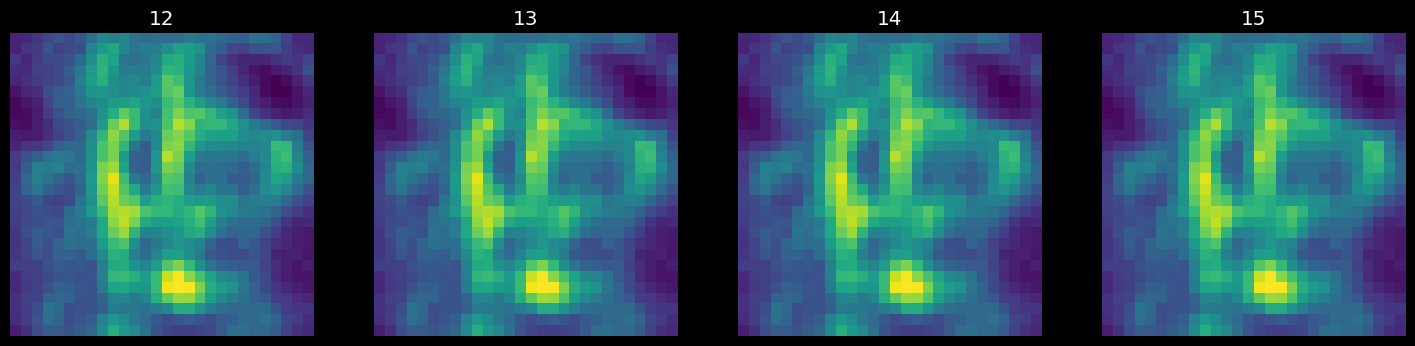

In [46]:
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [47]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

In [48]:
import numpy as np
from sklearn.manifold import TSNE

In [49]:
set_default(figsize=(15, 4))

In [50]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10, 15, 19)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

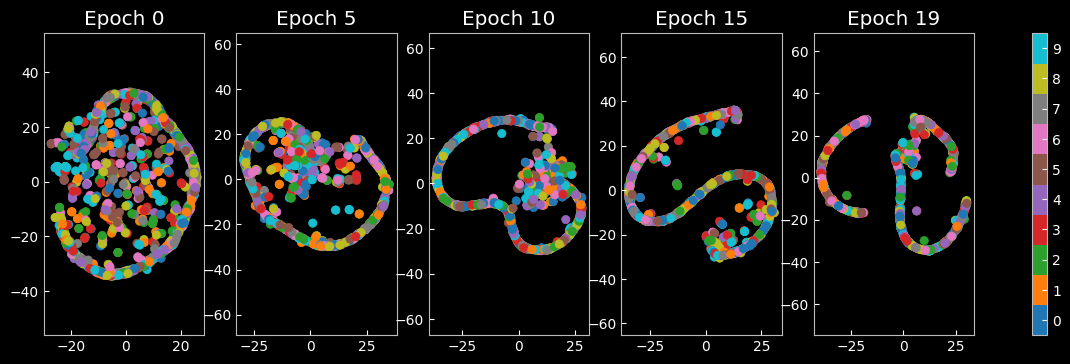

In [52]:
f, a = plt.subplots(ncols=5)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

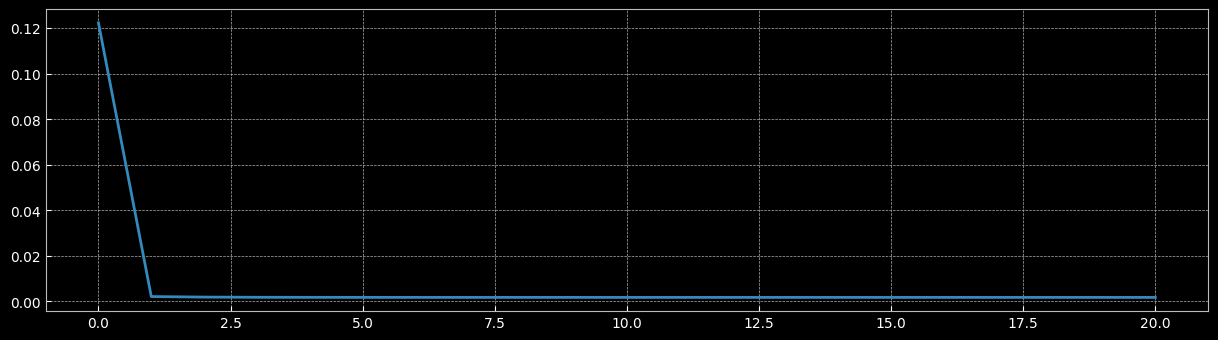

In [125]:
import matplotlib.pyplot as plt
import numpy as np

#for i in range(20):
x = np.linspace(0, 20, 21)
y = lossArray1

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)



plt.show()

# Questões
A medida que aumentamos a quantodade de epocas treinadas conseguimos observar a formação de clusters, como observado na figura acima, no entanto não ha separação dos rotulos no espaco latente, na projeção obtivemos uma variação na taxa de perda de  0,0022; cerca de 50% de melhora em relação ao inicio

##########################################################################

In [53]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [54]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [59]:
from torchvision.datasets import FashionMNIST

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    FashionMNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



O dataset ultilizado Fashion-MNIST, possui 70000 imagens de treinamento sendo divididas em 10 classes

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [62]:
learning_rate = 1e-3

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
)

Diferente do primeiro experimento, para esse experimento vamos usar o otimizador SGD para podermos comparar a diferença de desempenho entre os dois

In [63]:
def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='mean'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

Treinamento e teste do modelo, da mesma forma como no experimento anterior, utilizaremos 20 epocas

====> Test set loss: 0.0028
====> Epoch: 1 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 2 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 3 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 4 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 5 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 6 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 7 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 8 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 9 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 10 Average loss: 0.0027
====> Test set loss: 0.0028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


====> Epoch: 11 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 12 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 13 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 14 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 15 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 16 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 17 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 18 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 19 Average loss: 0.0027
====> Test set loss: 0.0028
====> Epoch: 20 Average loss: 0.0027
====> Test set loss: 0.0028


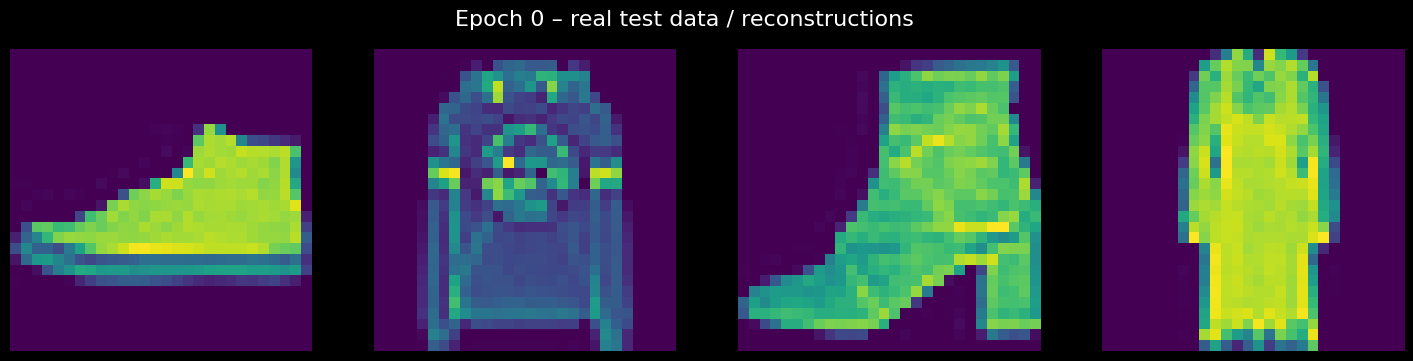

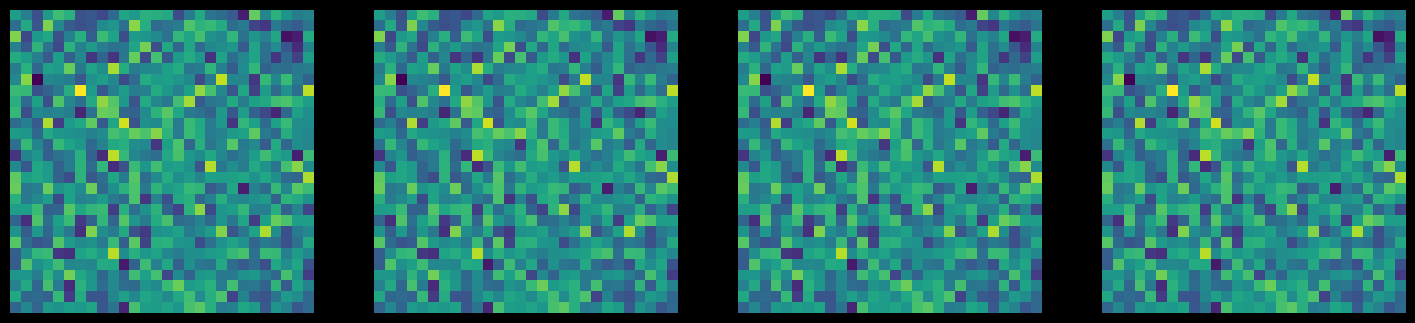

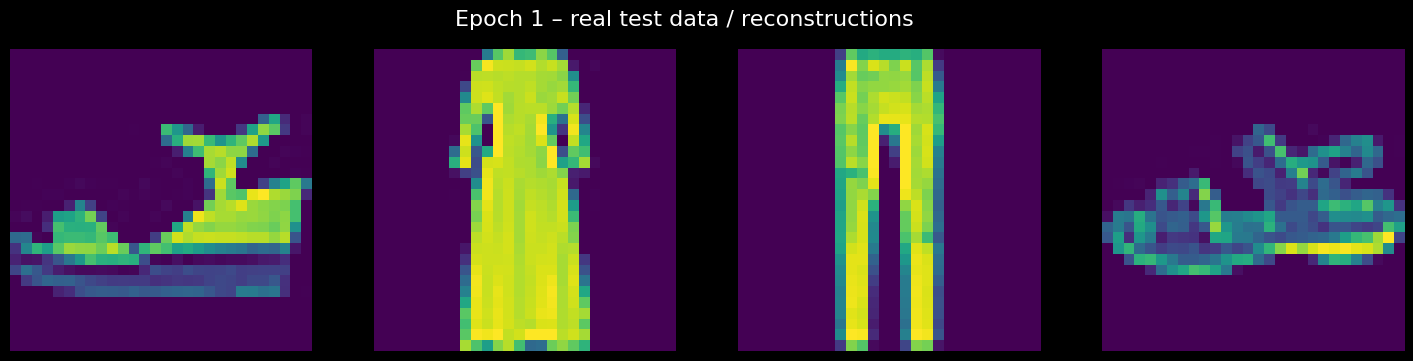

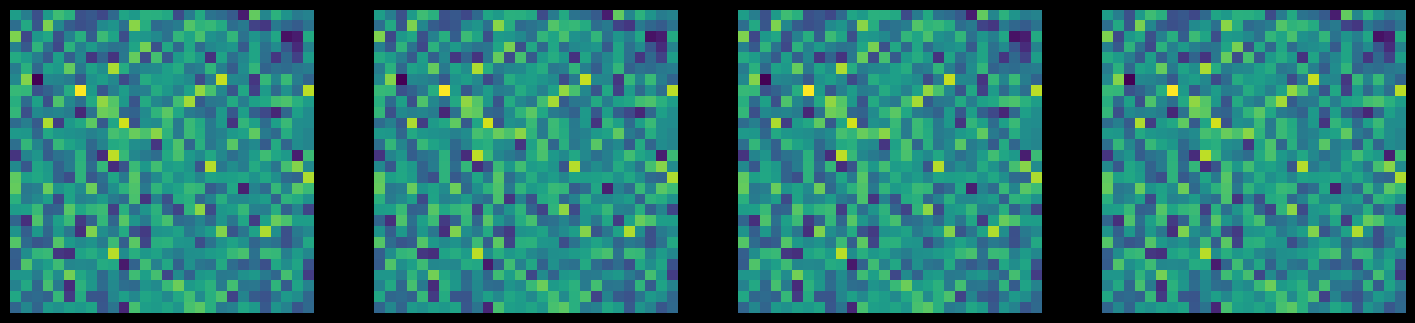

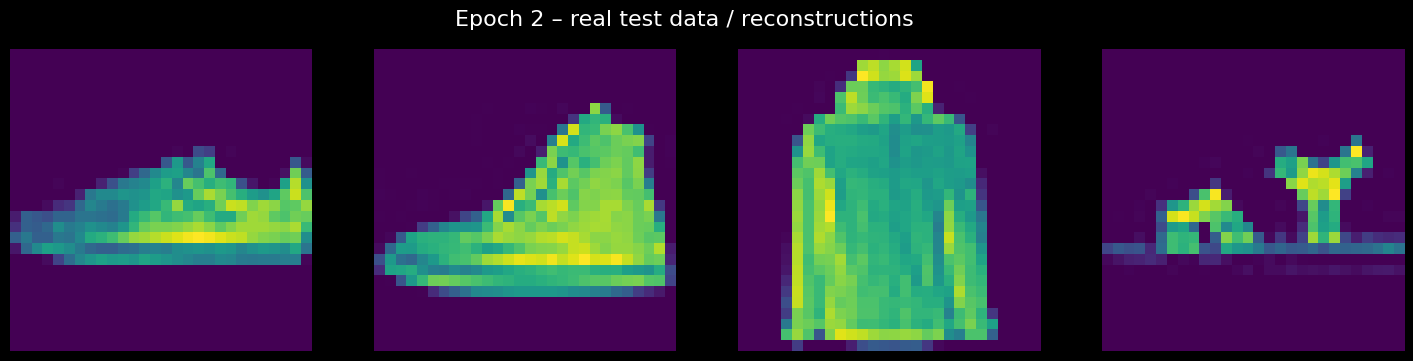

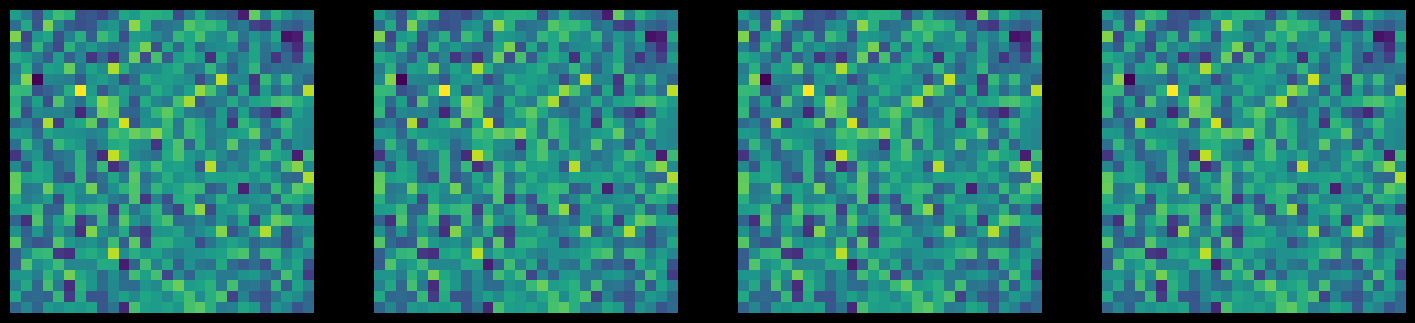

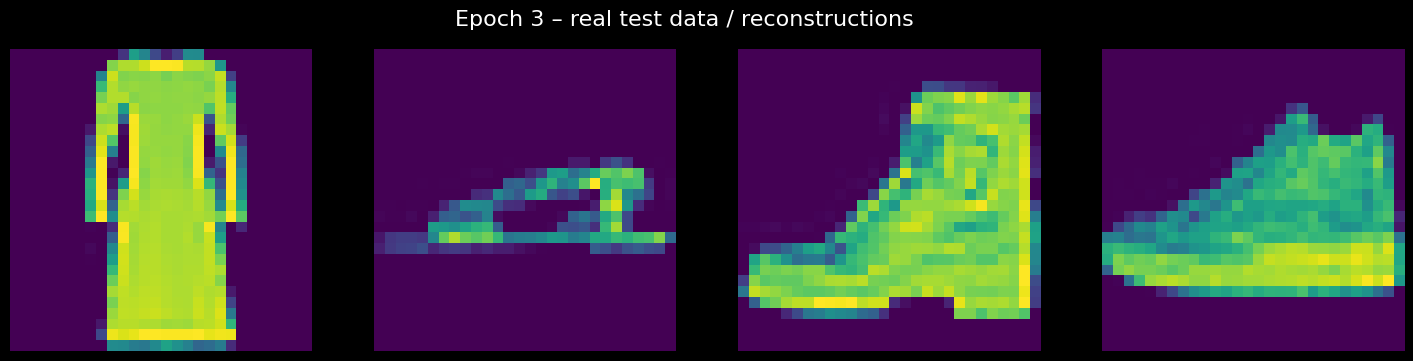

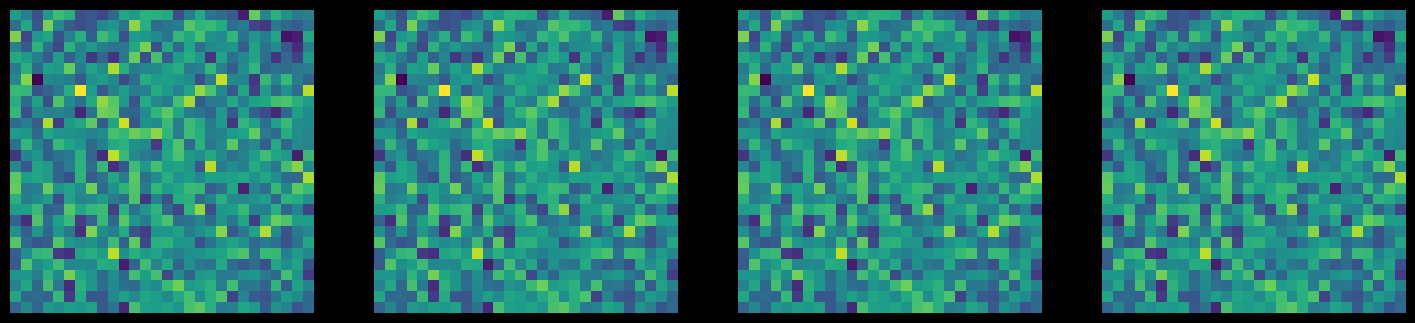

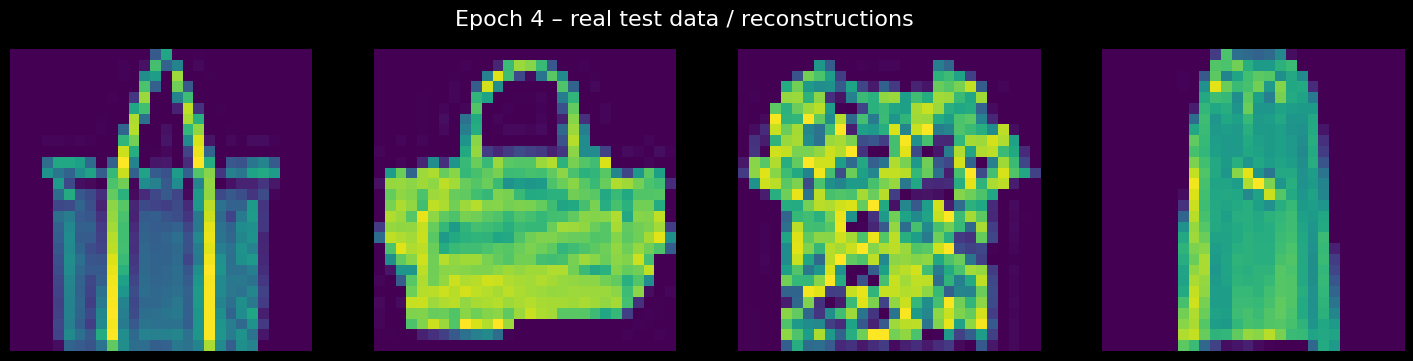

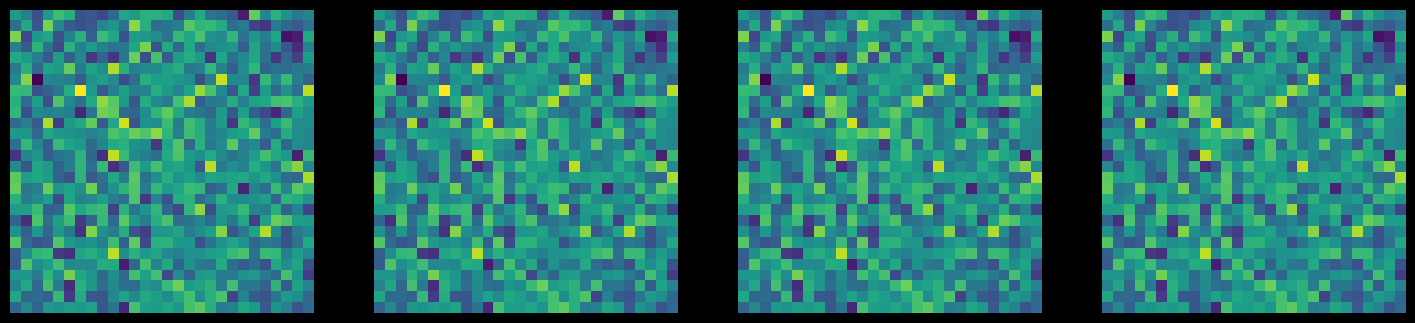

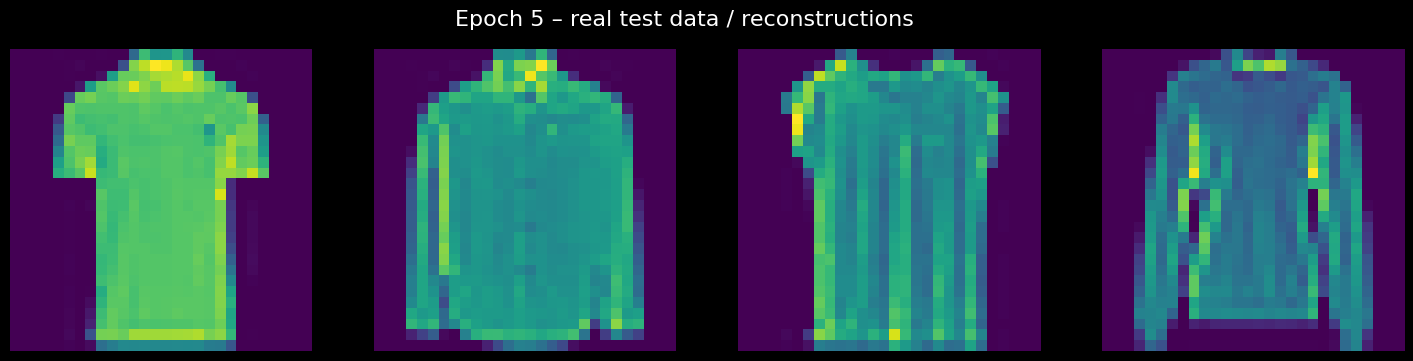

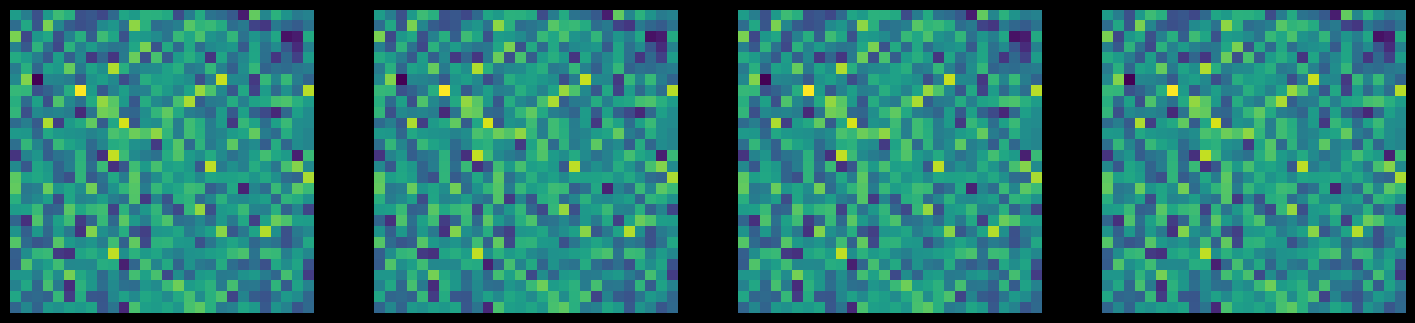

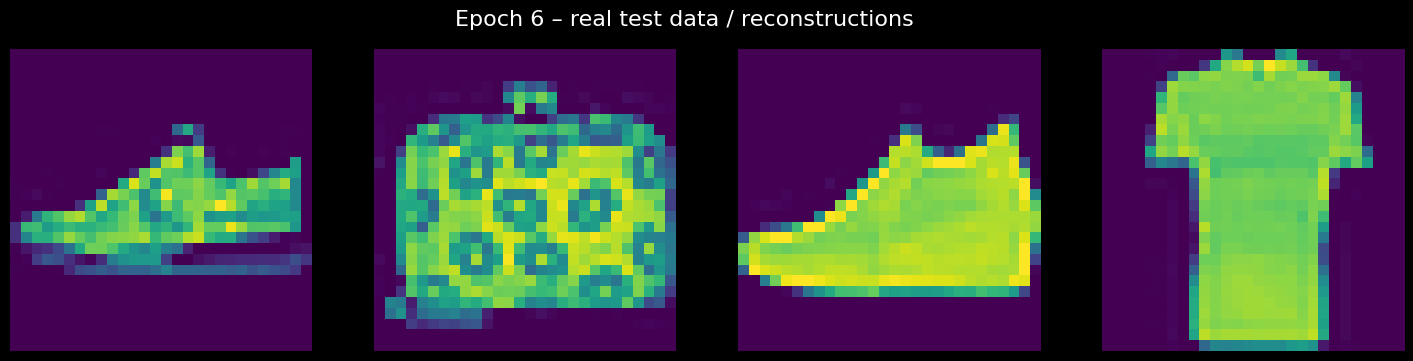

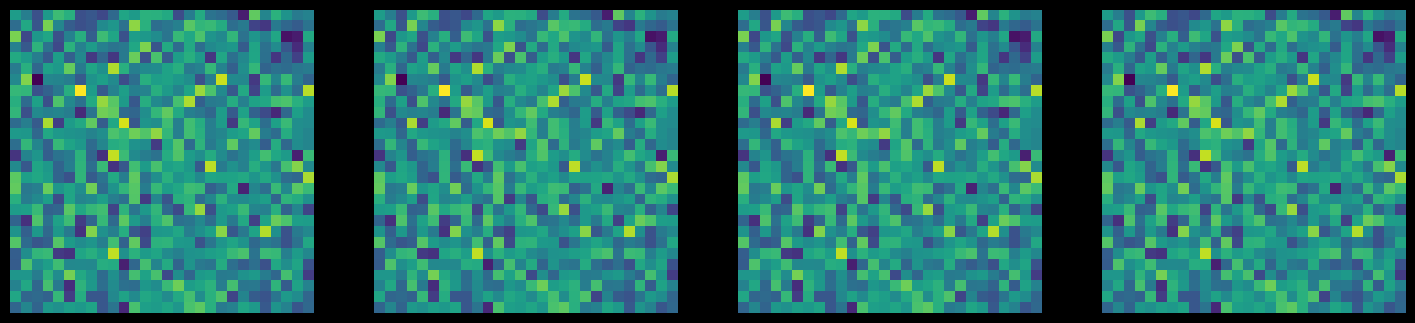

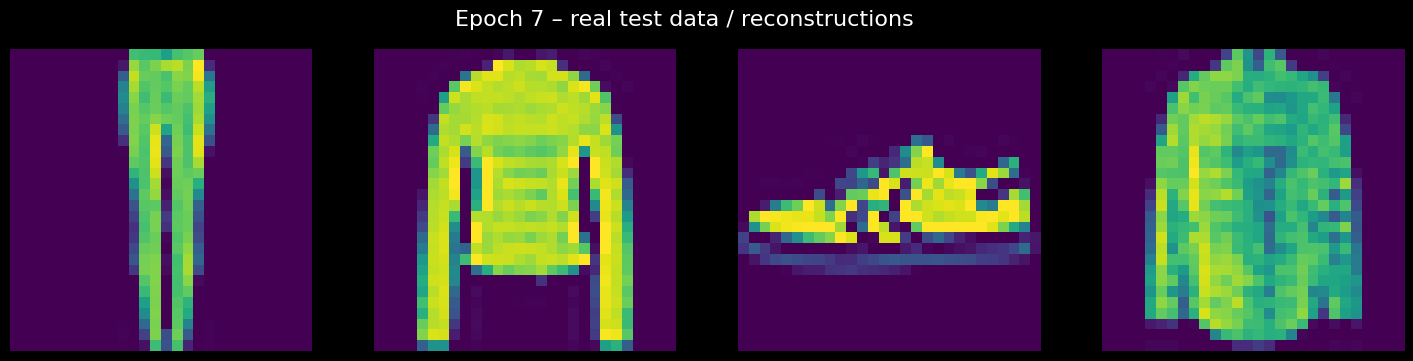

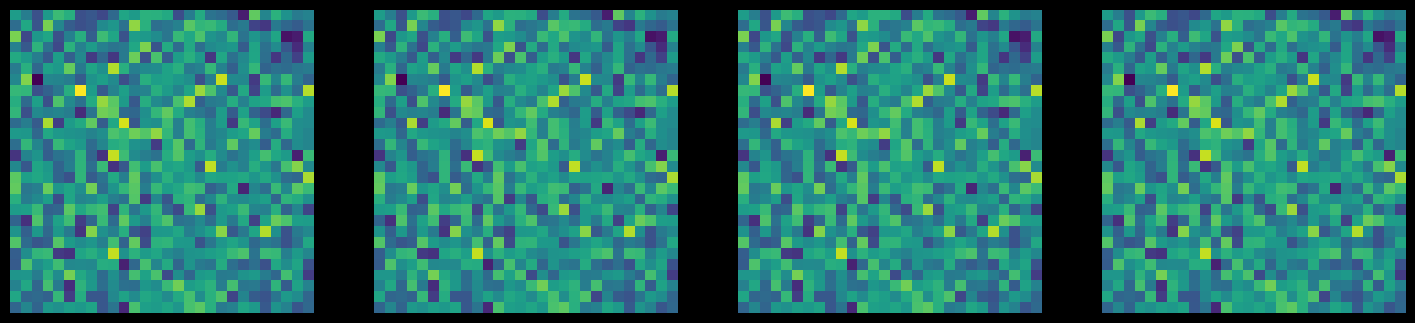

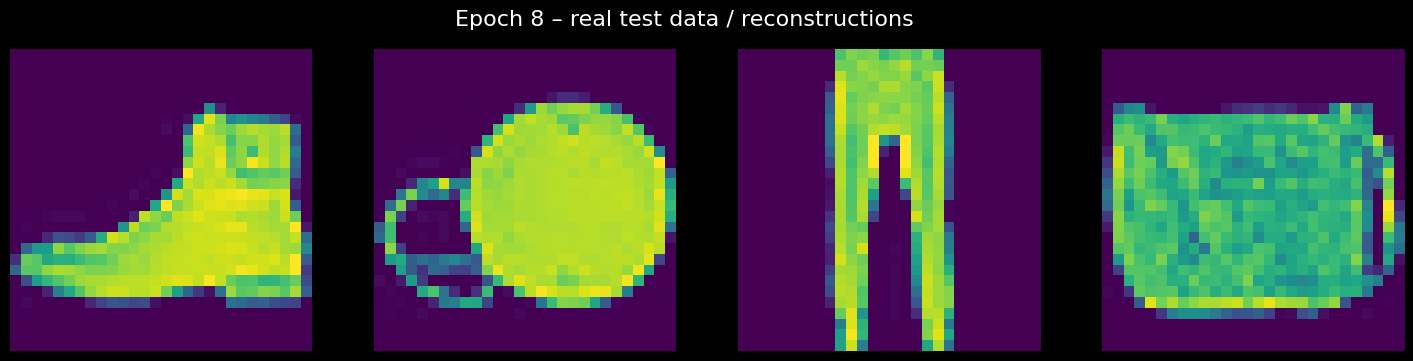

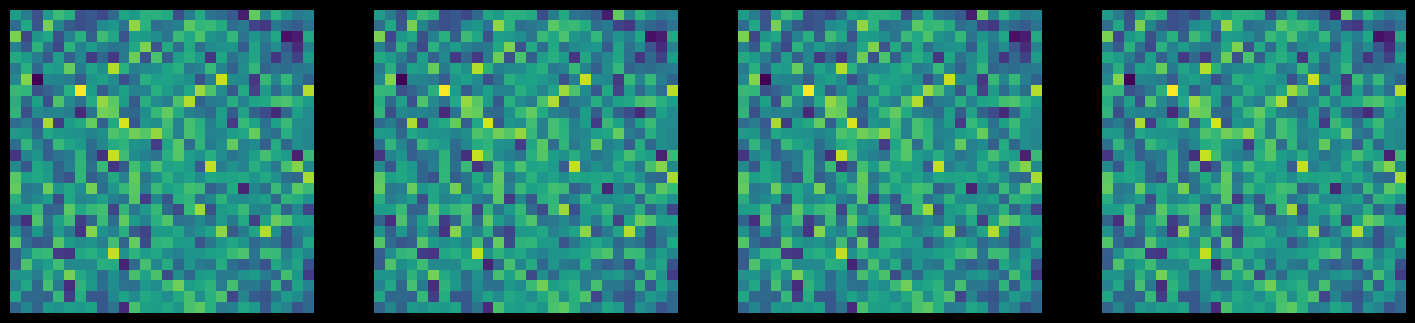

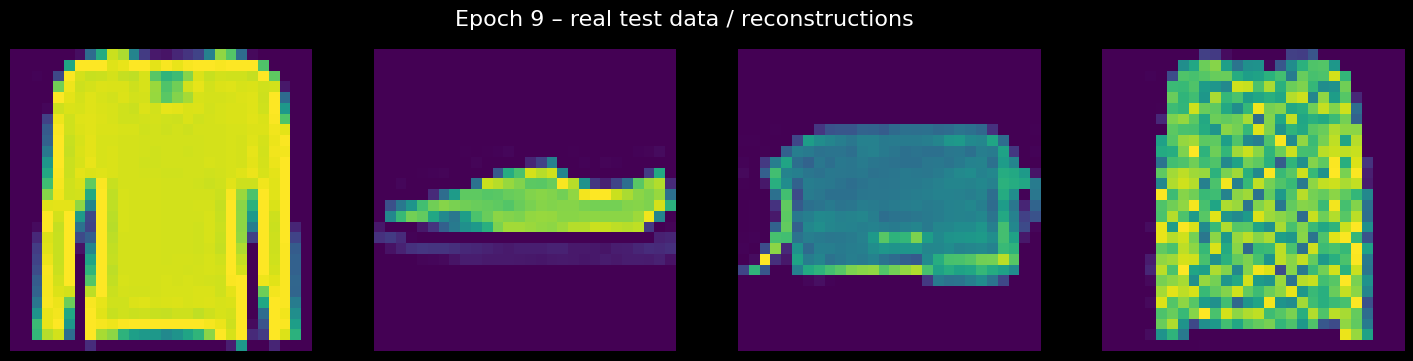

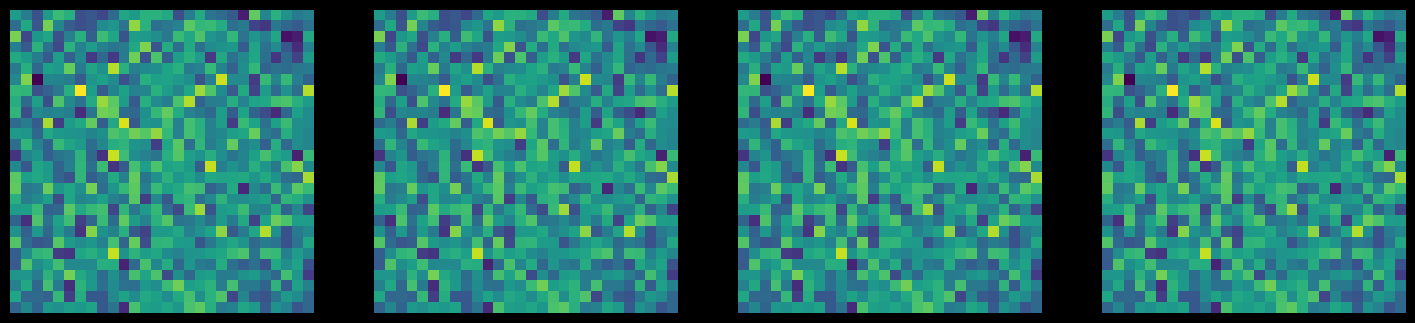

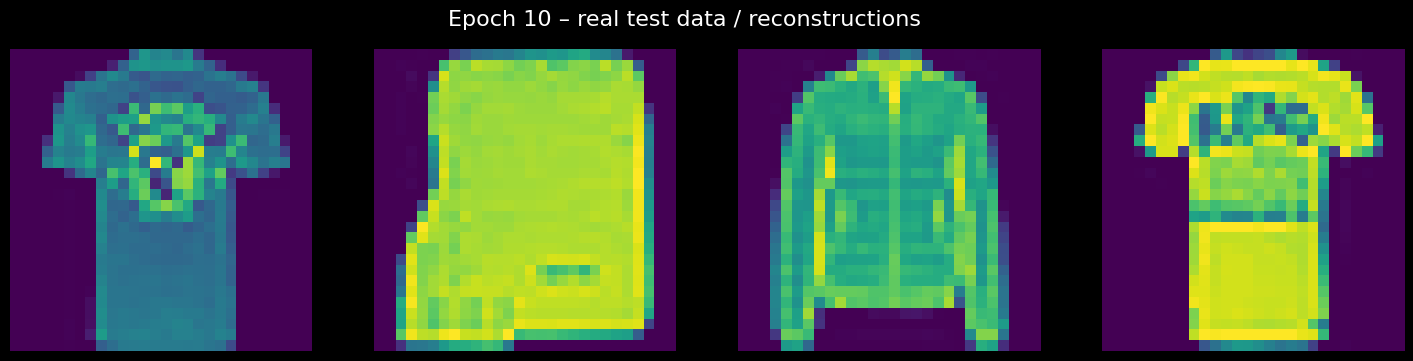

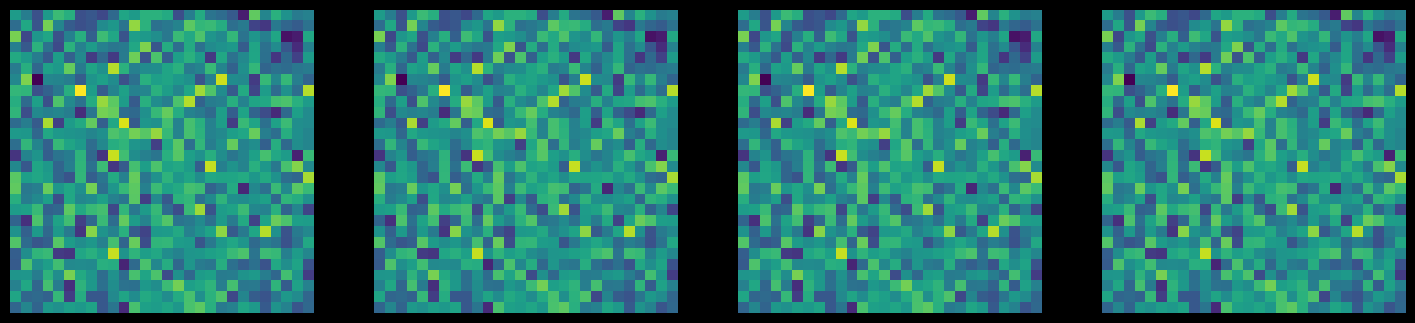

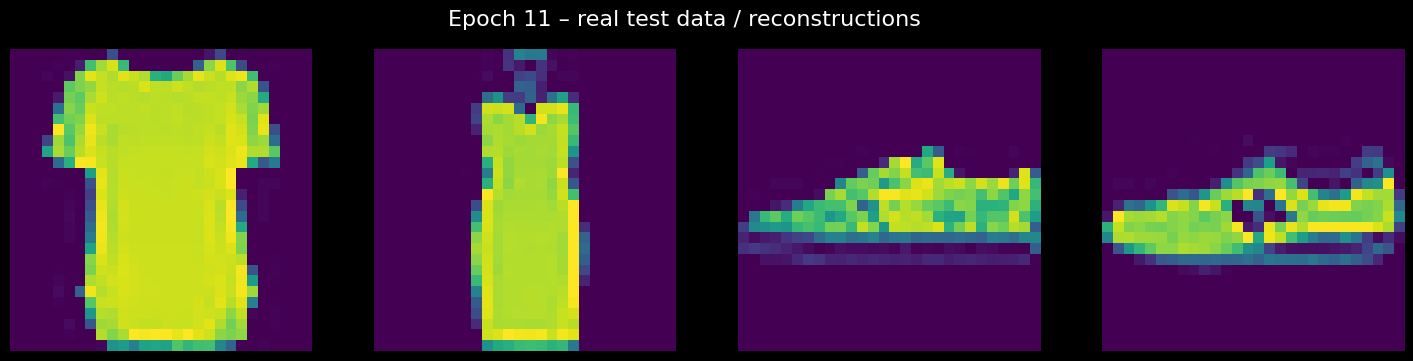

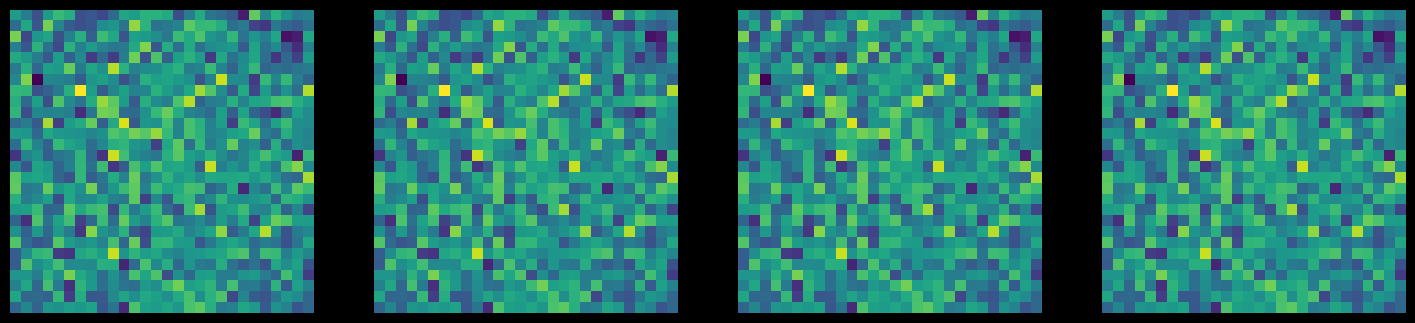

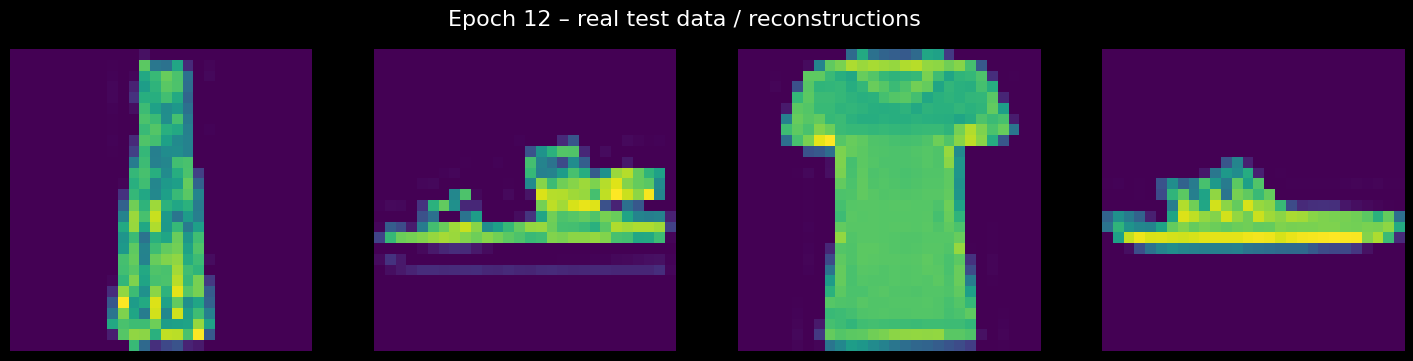

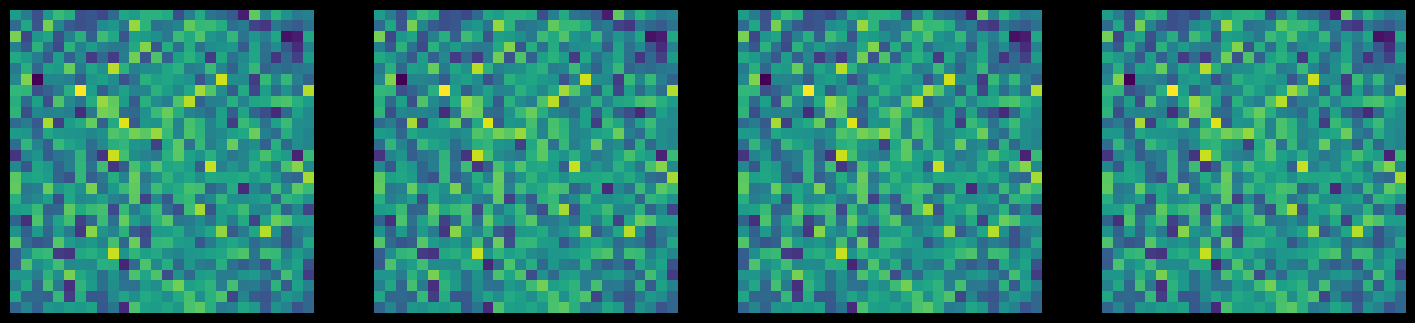

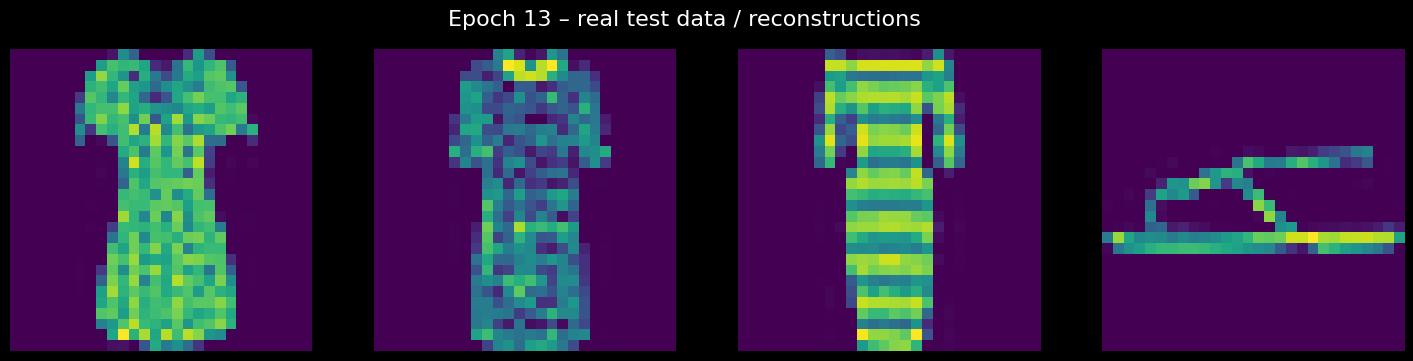

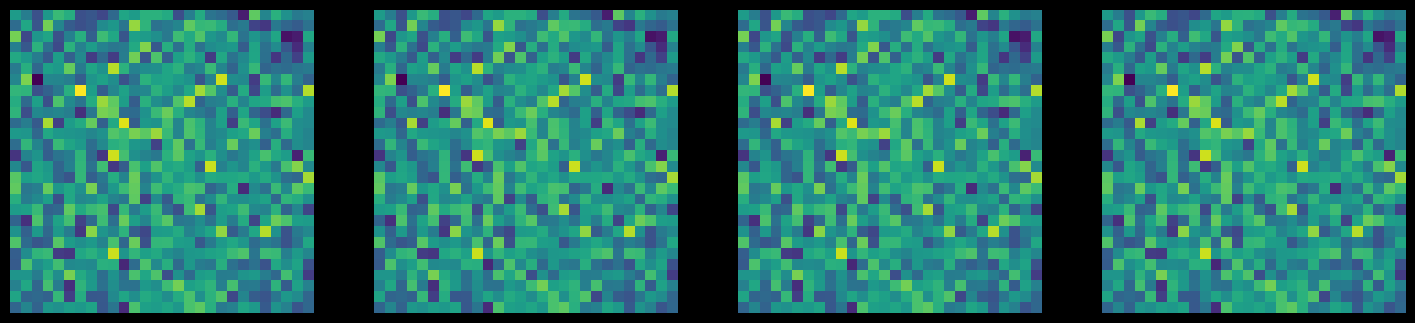

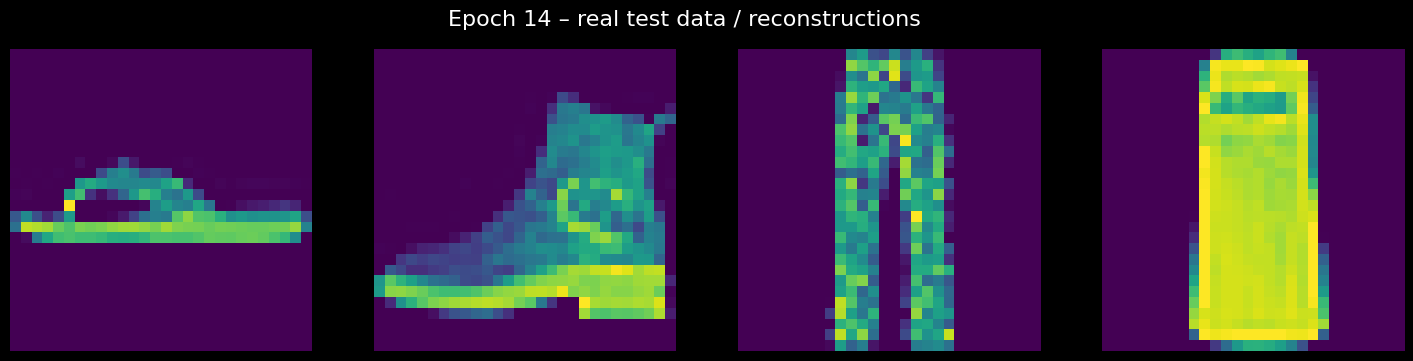

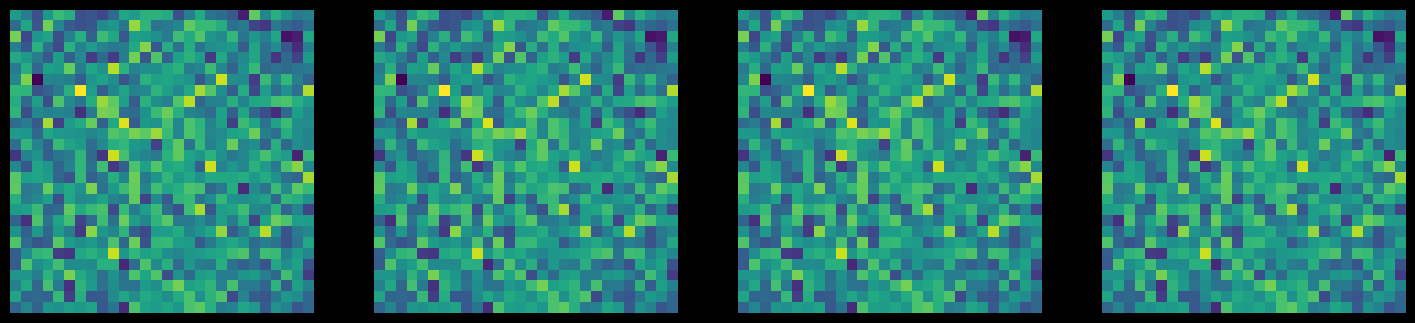

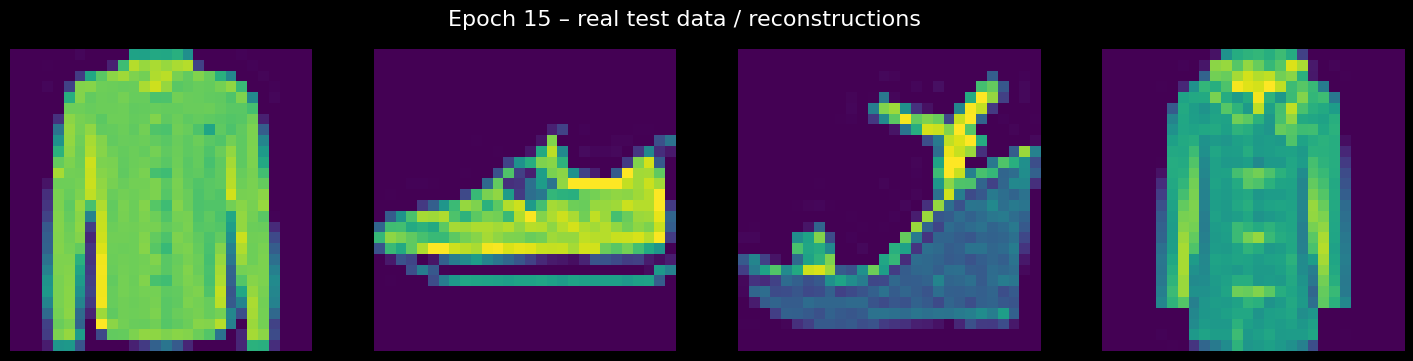

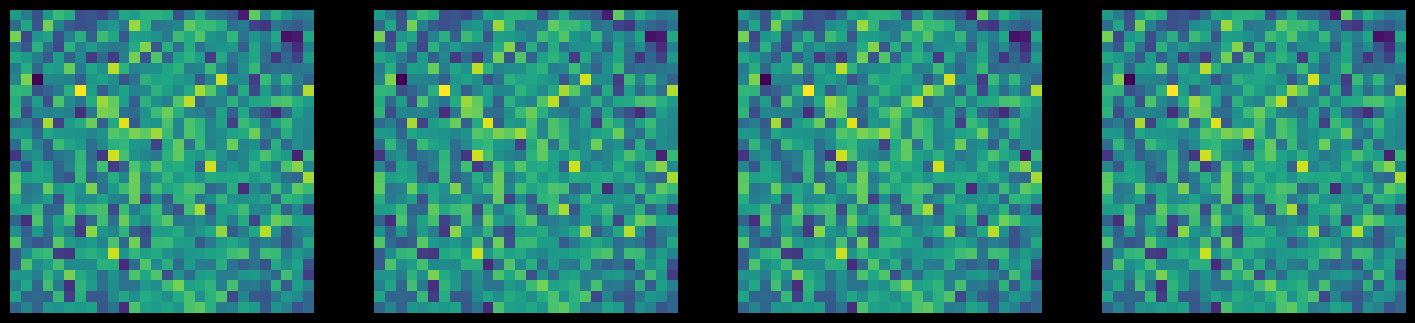

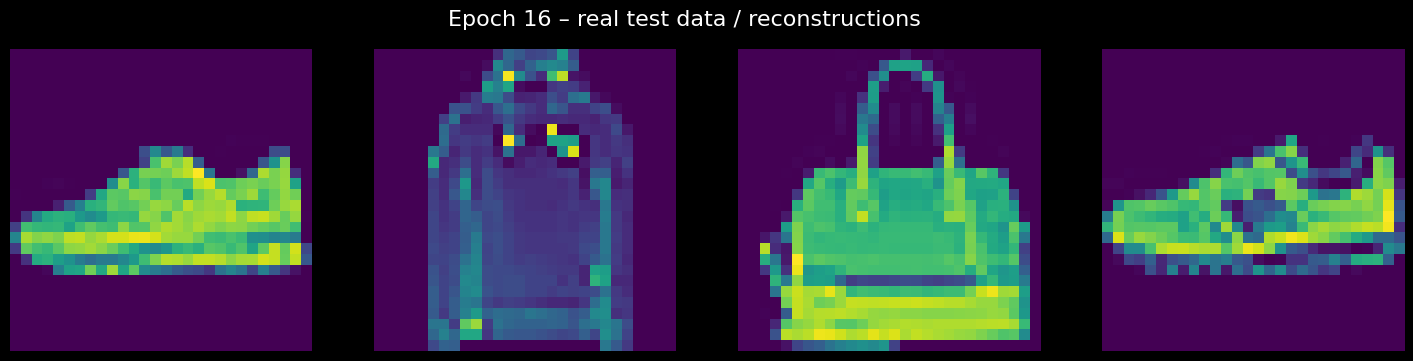

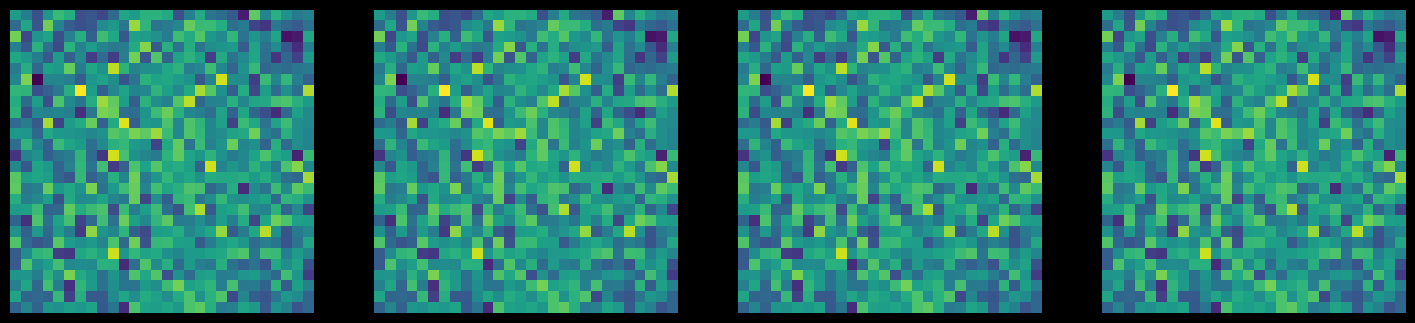

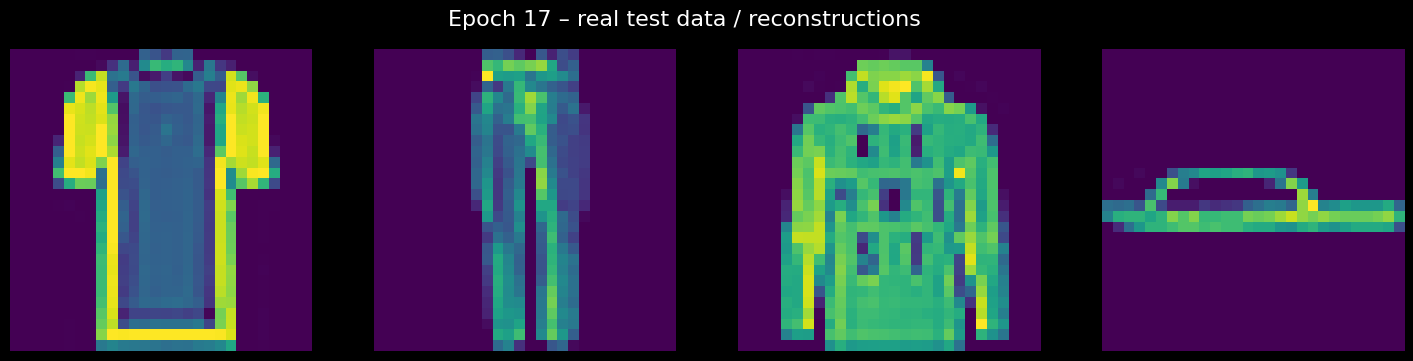

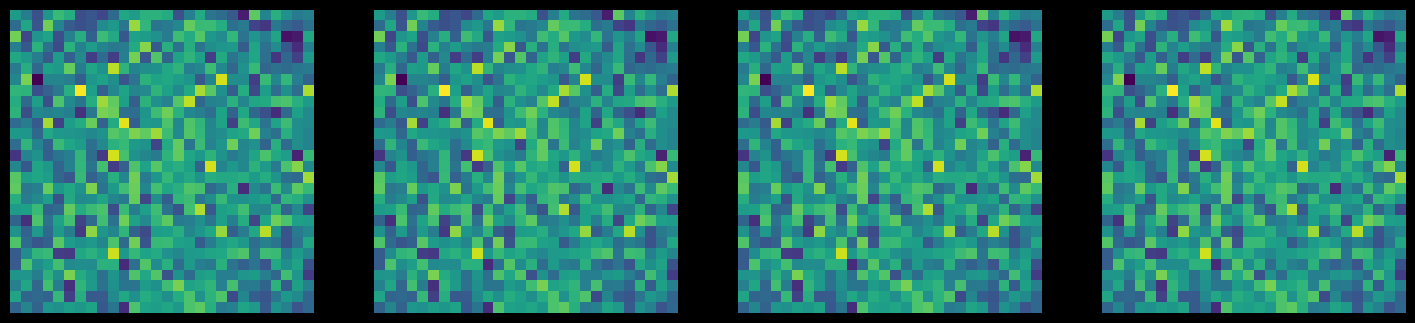

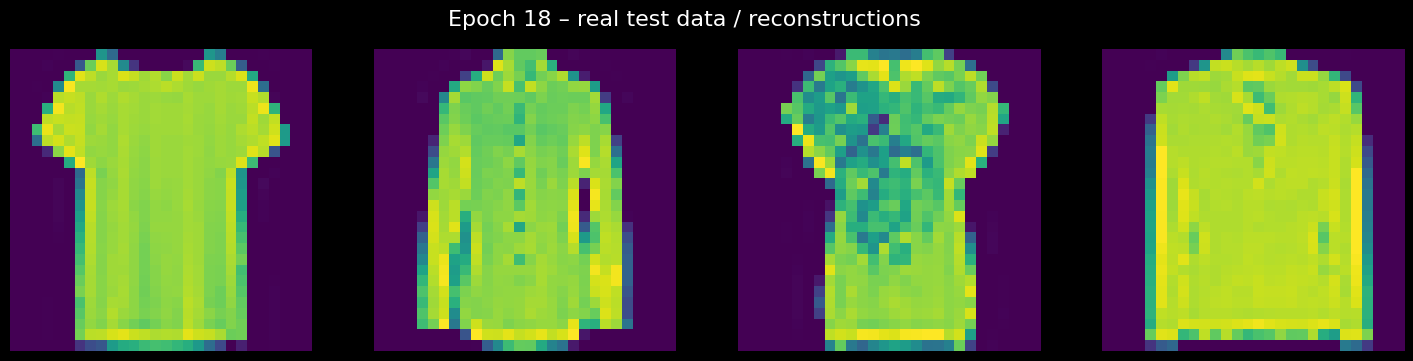

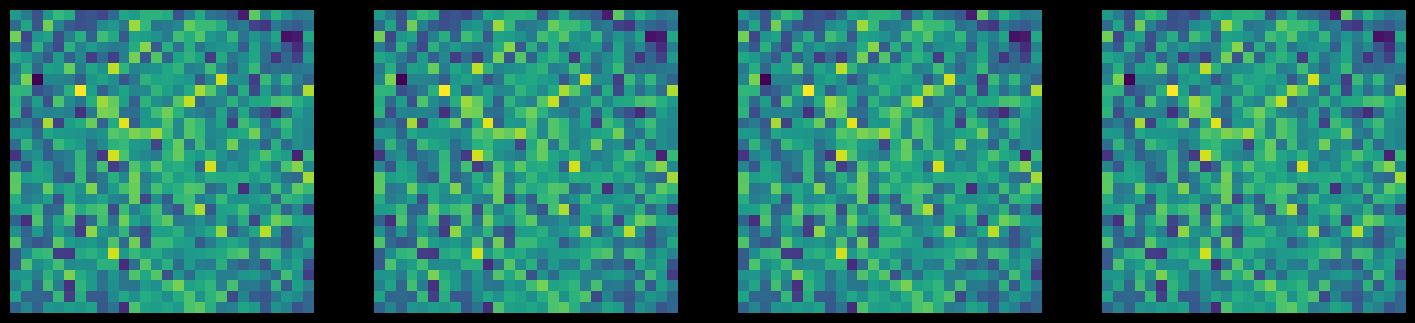

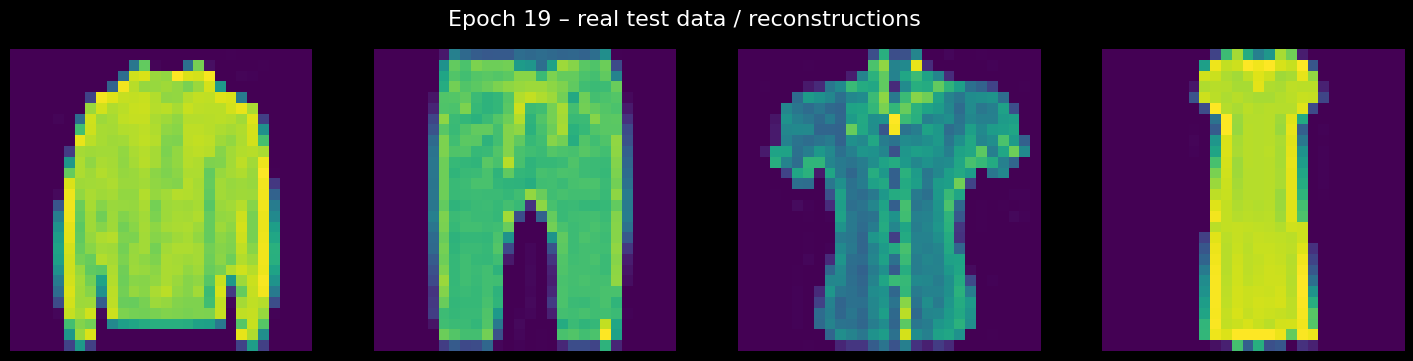

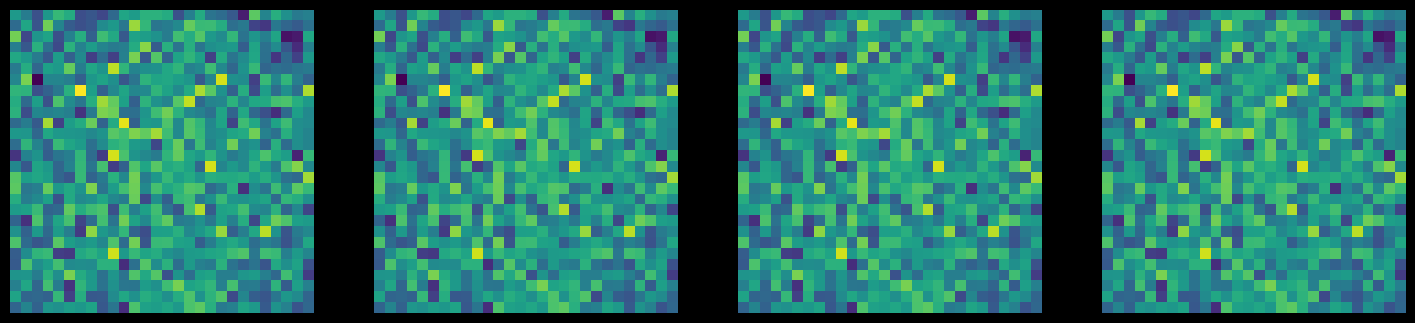

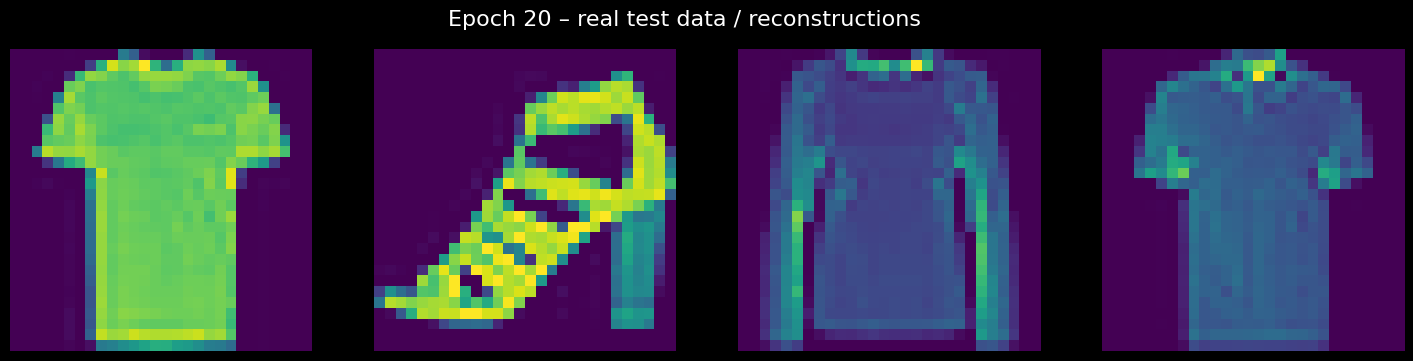

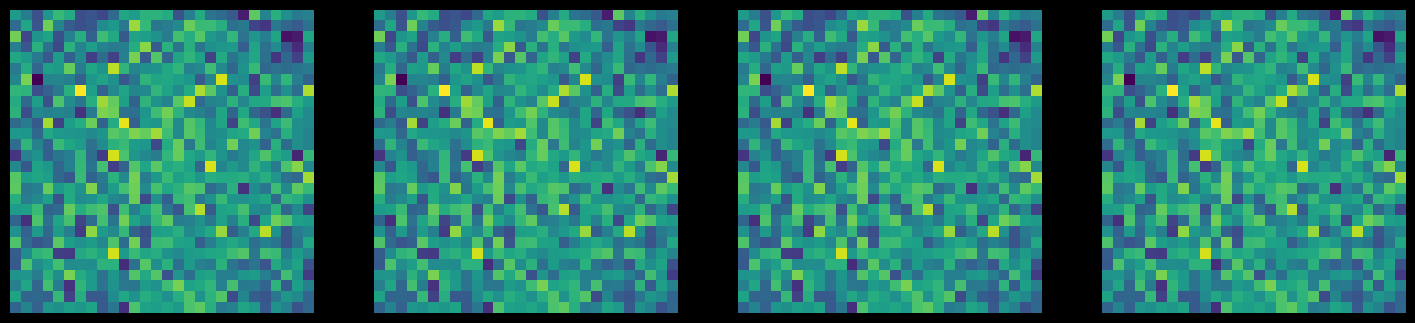

In [73]:
epochs = 20
lossArray = []
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    lossArray.append(test_loss)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

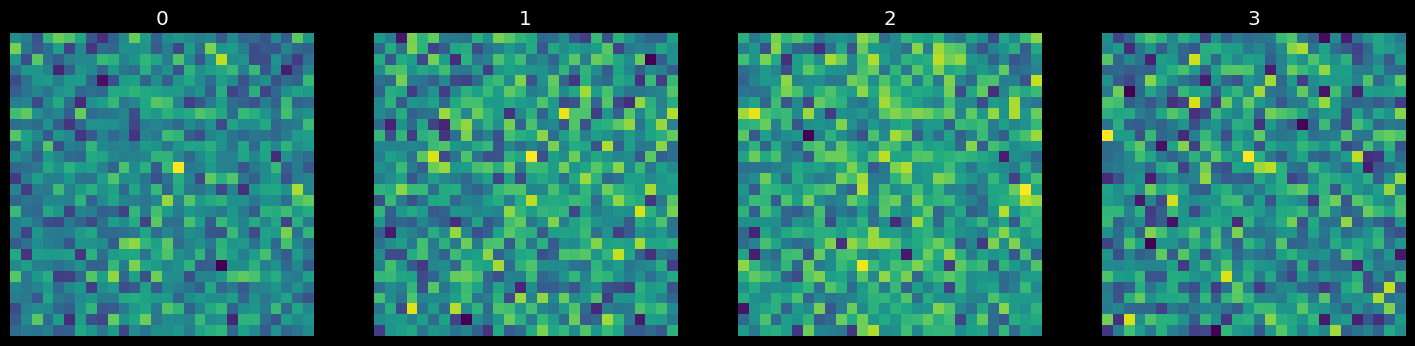

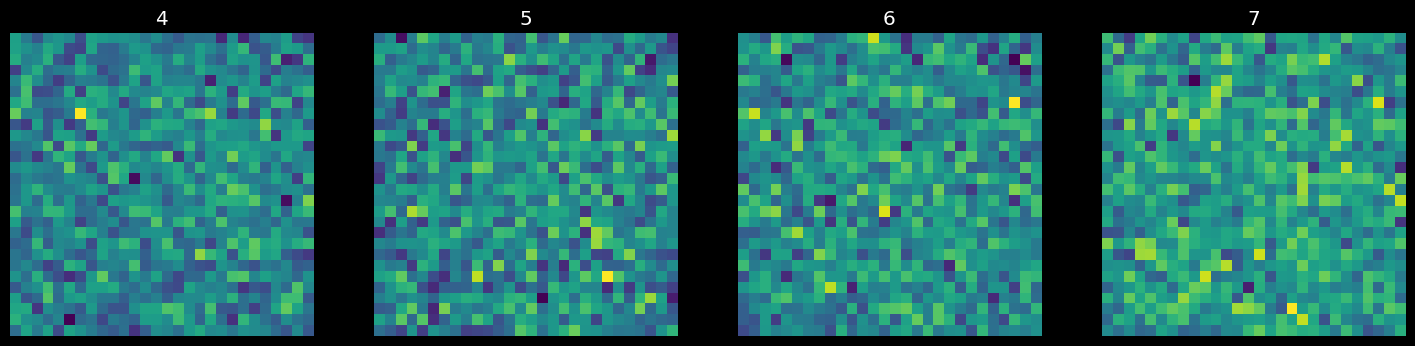

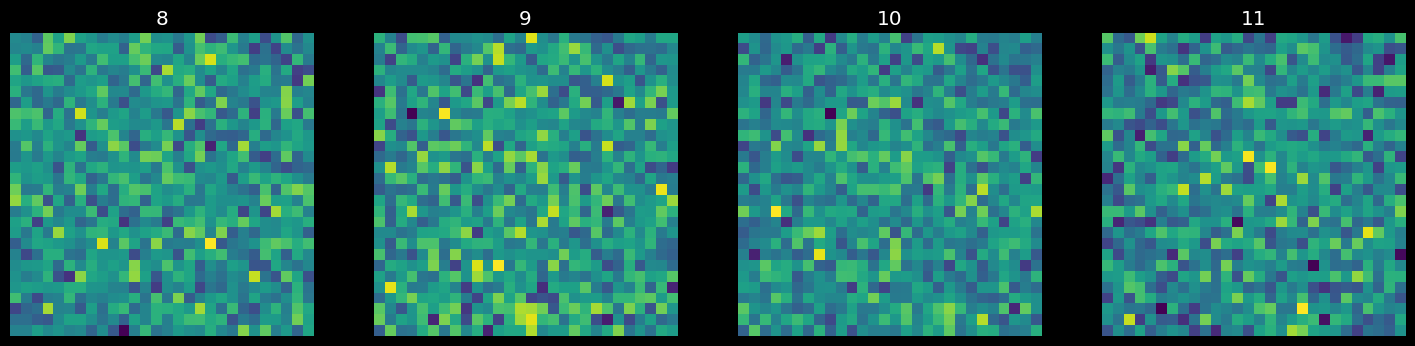

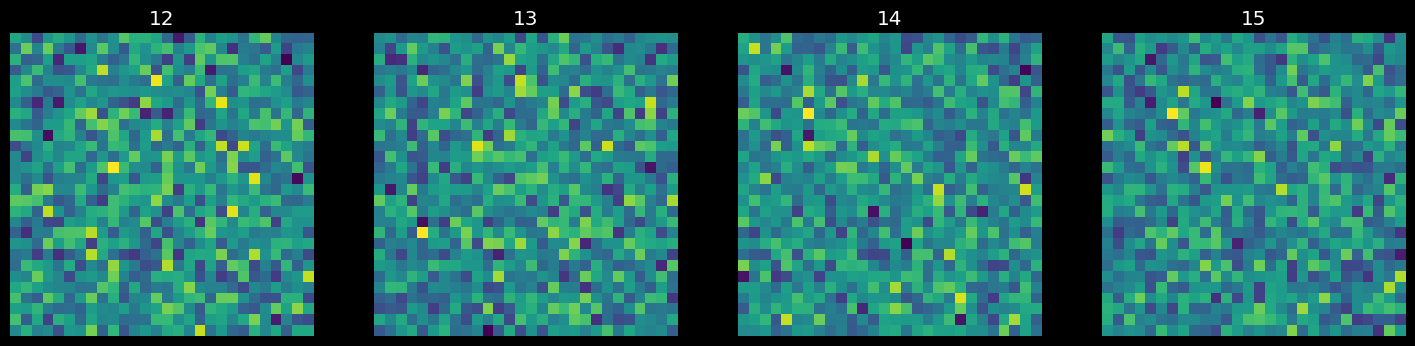

In [65]:
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

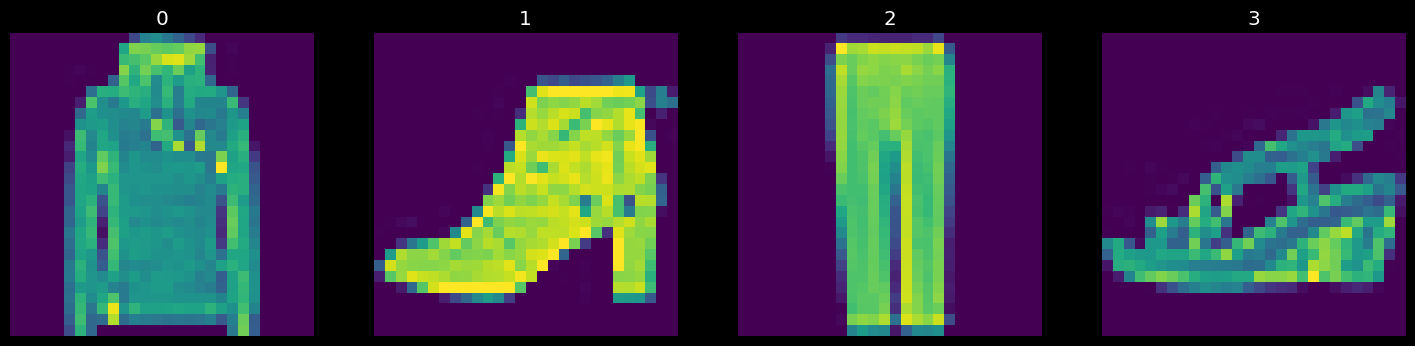

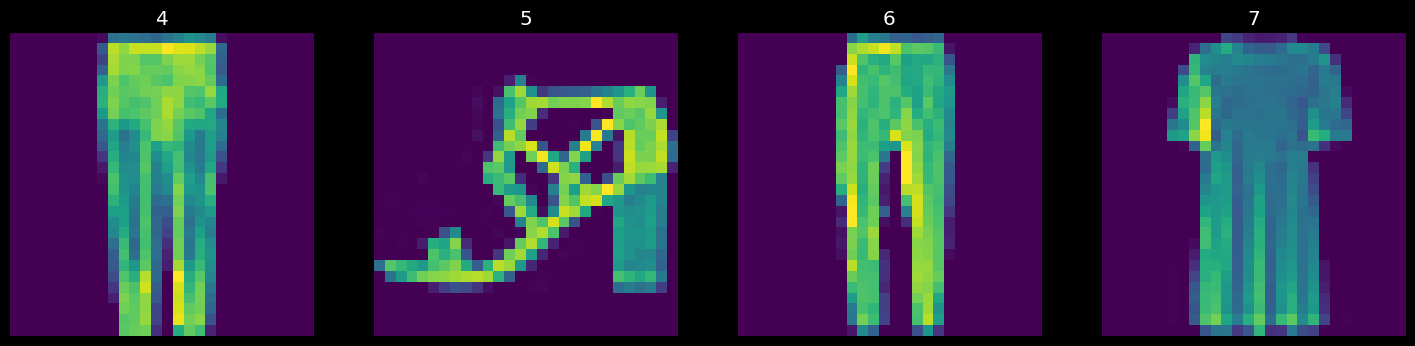

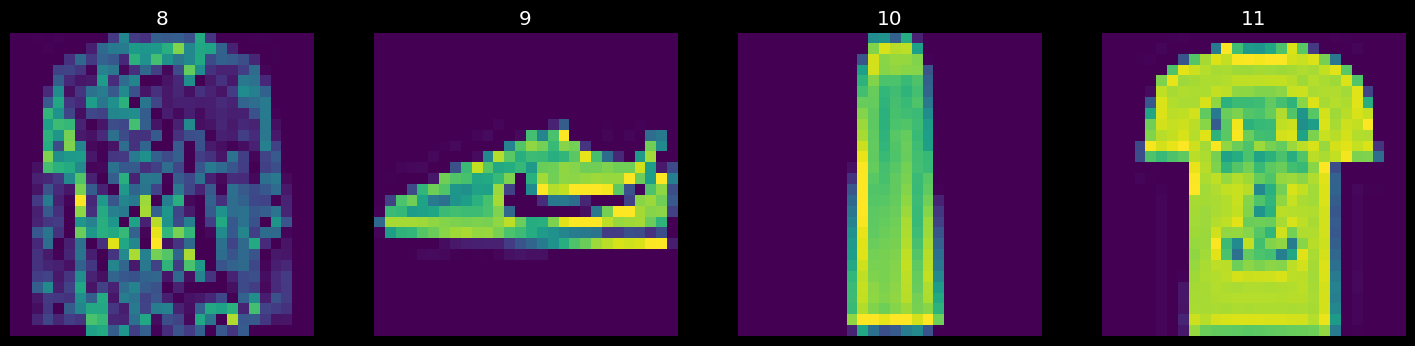

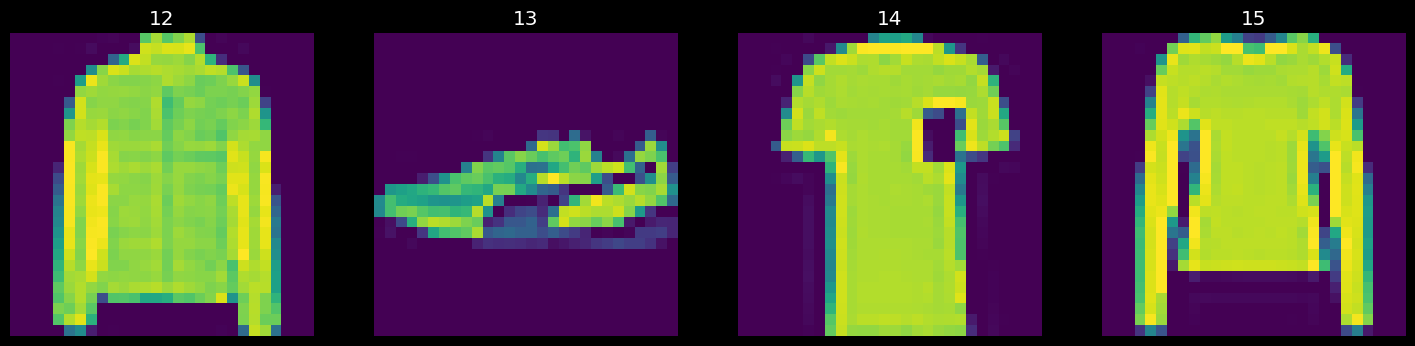

In [66]:
display_images(None, x, 4, count=True)

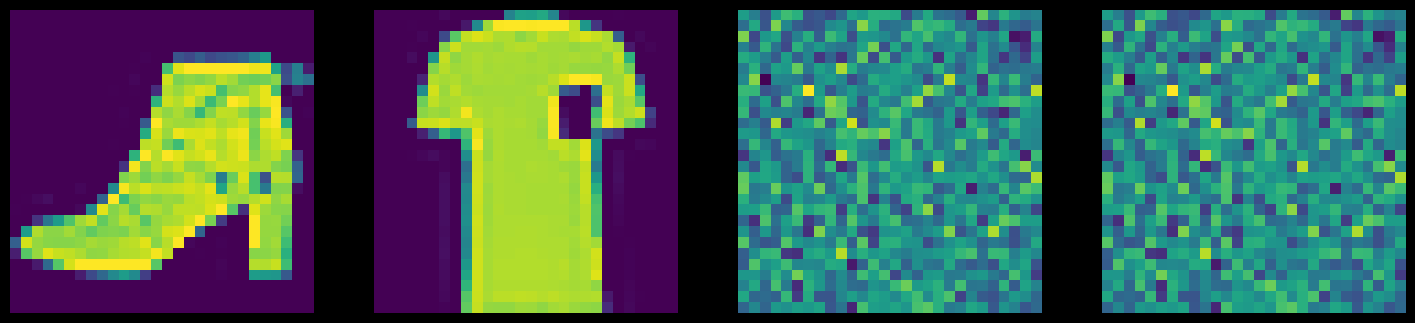

In [67]:
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

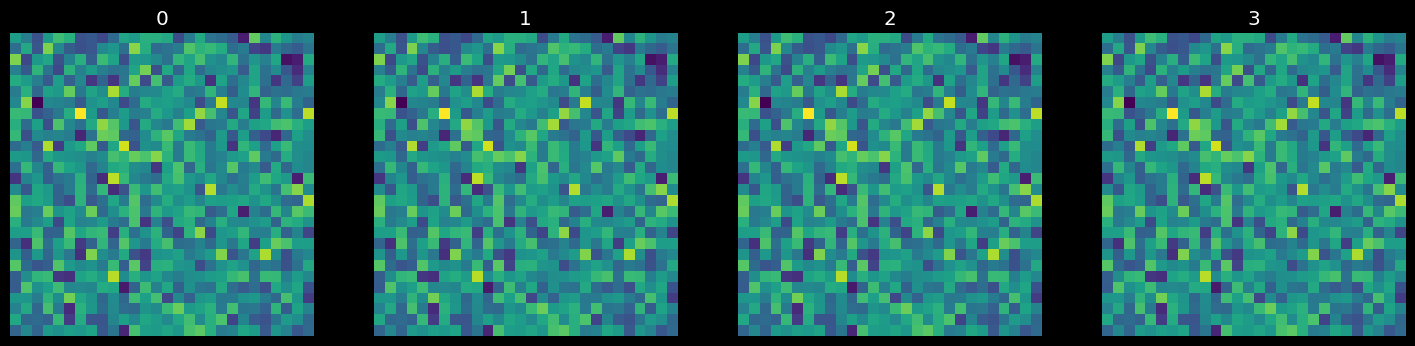

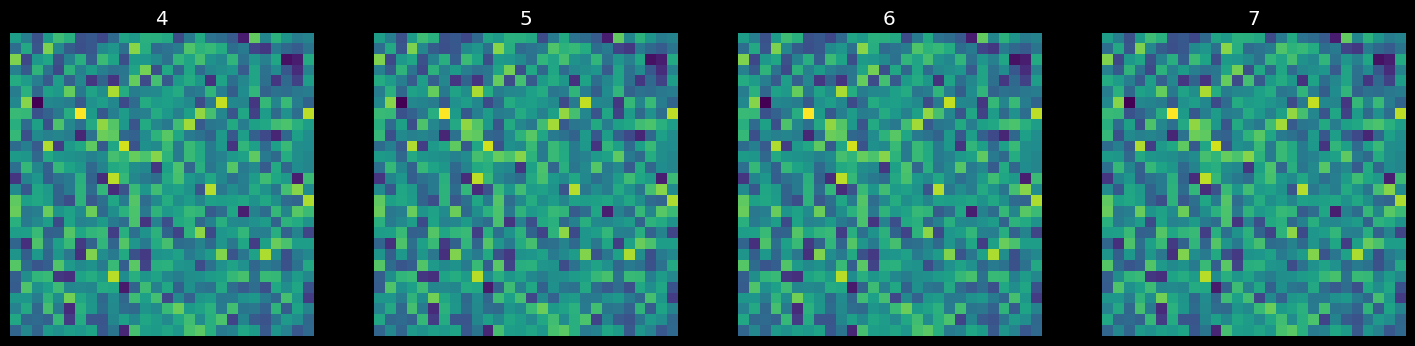

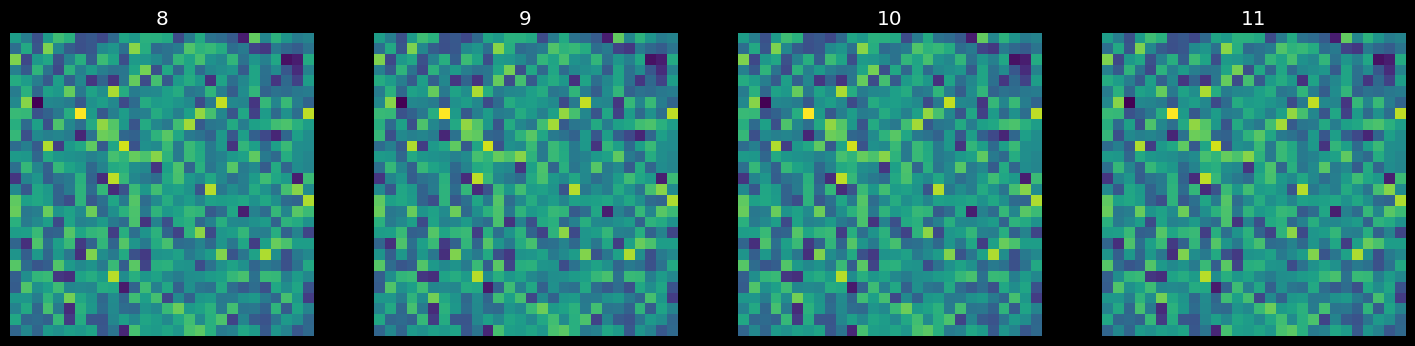

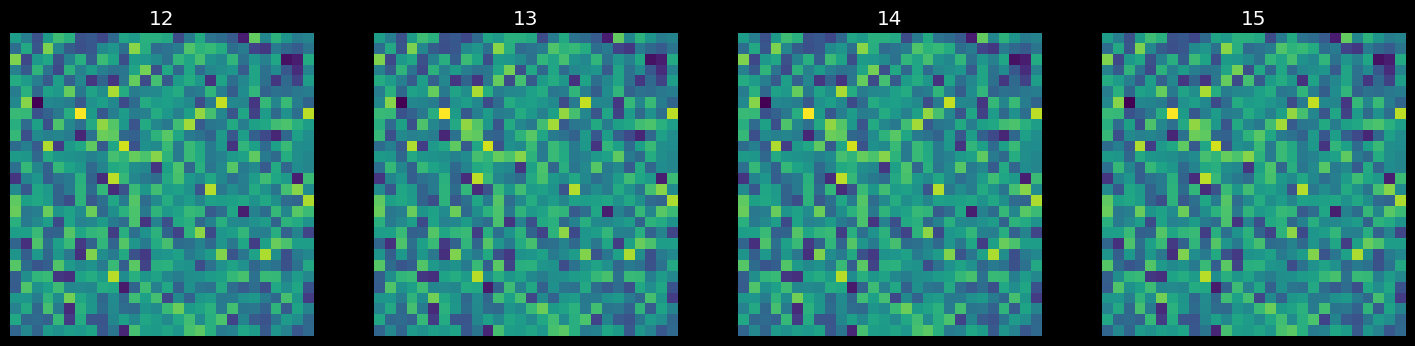

In [68]:
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [69]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10, 15, 19)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

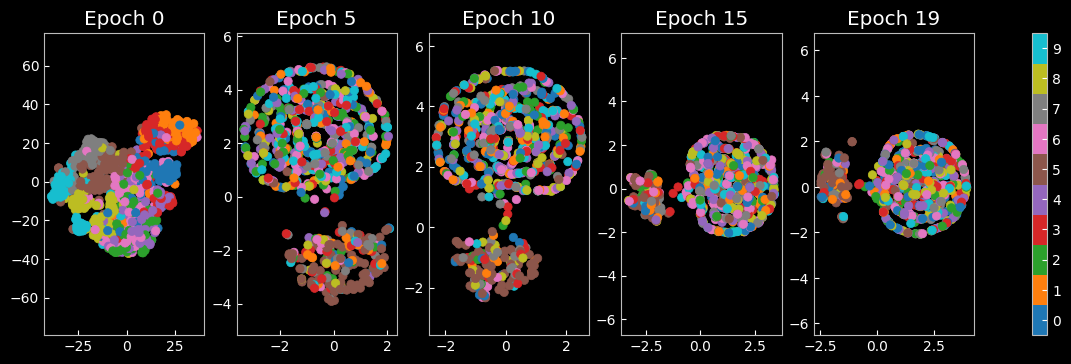

In [70]:
f, a = plt.subplots(ncols=5)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

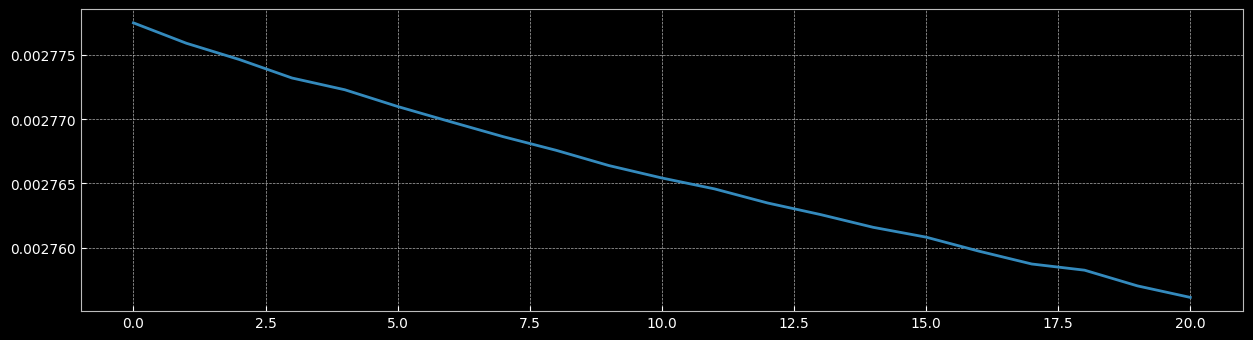

In [117]:
import matplotlib.pyplot as plt
import numpy as np

#for i in range(20):
x = np.linspace(0, 20, 21)
y = lossArray

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)



plt.show()